In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from tensorflow import keras
from sklearn.metrics import matthews_corrcoef, accuracy_score, root_mean_squared_error, mean_squared_error, mean_absolute_error, precision_score, confusion_matrix, multilabel_confusion_matrix, classification_report, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm
import time
from sklearn.preprocessing import StandardScaler, LabelEncoder
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import gc
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

2025-04-08 16:08:26.339857: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744117706.413691   58514 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744117706.435840   58514 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744117706.575272   58514 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744117706.575295   58514 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744117706.575299   58514 computation_placer.cc:177] computation placer alr

# Functions

In [79]:
def visualize_CM(matrix):
    """
    Visualize Correlation Matrix
    """
    sns.heatmap(matrix,annot=True)

def result_plot(_dict, name, folder, model_name):
    """
    Plot results for multiclass classification
    """
    attacks = {}
    higher = ["F1", "Accuracy", "Precision", "Recall", "MCC", "precision", "recall", "f1-score", "support", 'Benign', 'Bruteforce', 'DDoS', 'DoS', 'Mirai', 'Recon', 'Spoofing',
       'Web']
    fig, ax = plt.subplots(figsize=(10,10))
    if name in higher:
        tmp = sorted(_dict.items(), key = lambda x:x[1])
    else:
        tmp = sorted(_dict.items(), key = lambda x:x[1], reverse=True)
    for x in tmp:
        attacks[x[0]] = x[1]
    ax.bar(attacks.keys(), attacks.values())
    rects = ax.patches
    results = [i for i in attacks.values()]
    labels = [f"{results[i]:.6f}" for i in range(len(rects))]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom"
        )
    if name in higher:
        name = name.capitalize()
        ax.set_title(f'{name} (higher is better)', fontsize=16, fontweight="bold")
    else:
        ax.set_title(f'{name} (lower is better)', fontsize=16, fontweight="bold")
    ax.set_xlabel(f'{name}')
    ax.set_ylabel('Score')
    ax.grid(which='Major', axis='both')
    ax.set_axisbelow(True)
    if (model_name == ""):
        plt.savefig(f"images/results/{folder}/90000/{name}.png")
    else:
        plt.savefig(f"images/results/{folder}/90000/{name}_{model_name}.png")

def plot_mc(y_pred, y_test, model_name, mc_results = {}):
    """
    Plots Precision, Recall and F1 scores for each class in multiclass classification
    """
    cr = classification_report(y_pred, y_test, output_dict=True)
    for key, name in cr.items():
        if key not in ['accuracy', 'macro avg', 'weighted avg'] and int(key) in attack_dict:
            mc_results[attack_dict[int(key)]] = cr[key]
    mc_results = pd.DataFrame(mc_results).drop(['support'], axis = 0)
    for key in mc_results.keys():
        result_plot(mc_results[key], key, "multiclass_by_class", model_name)

# Load data

In [3]:
data = pd.read_csv('data/CIC_IoT2023/custom/multiclass_classification_data_90000.csv')

In [6]:
data = data.drop(['Unnamed: 0', 'label'], axis=1)

In [7]:
data.head()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,Attack Type
0,0.0,0.0,0.99,65.27,1.232415,1.232415,0.0,0.0,0.0,0.0,...,0.617394,42.18,8.312856e+07,9.5,9.184764,0.874489,2.990124,0.13,141.55,DDoS
1,0.0,54.0,6.00,64.00,31.840037,31.840037,0.0,0.0,1.0,0.0,...,0.000000,54.00,8.309343e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS
2,0.0,0.0,0.99,63.36,2.481472,2.481472,0.0,0.0,0.0,0.0,...,0.617394,42.18,8.314964e+07,9.5,9.184764,0.874489,2.990124,0.13,141.55,DDoS
3,0.0,54.0,6.00,64.00,4.499163,4.499163,0.0,0.0,0.0,0.0,...,0.000000,54.00,8.333215e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS
4,0.0,54.0,6.00,64.00,15.849033,15.849033,0.0,0.0,0.0,0.0,...,0.000000,54.00,8.307156e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS


In [8]:
data.tail()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,Attack Type
7995,1.245453,84831.8,6.0,62.3,59.269257,59.269257,0.0,0.0,0.0,0.0,...,529.760119,623.2,1.879692e-03,5.5,44.798738,749.193946,352519.133101,0.8,38.5,Bruteforce
7996,1.549077,1116.1,7.1,82.0,184.752583,184.752583,0.0,0.0,0.0,0.0,...,472.746293,214.9,1.666013e+08,13.5,26.110301,670.027076,225374.808644,1.0,244.6,Bruteforce
7997,1928.654402,69985.6,9.8,89.0,0.444028,0.444028,0.0,0.0,0.0,0.0,...,53.597589,108.2,2.198360e-02,5.5,13.710583,75.798437,3803.107186,0.8,38.5,Bruteforce
7998,7.056125,1005.2,6.0,62.2,6.904529,6.904529,0.0,0.0,0.0,0.0,...,83.988279,130.8,1.156039e-02,5.5,16.163288,118.777363,8923.574843,0.9,38.5,Bruteforce
7999,588.626037,45848.8,7.6,139.4,5.227422,5.227422,0.0,0.0,0.0,0.0,...,56.285161,112.7,3.807089e-02,5.5,13.779049,79.599238,3903.543166,0.9,38.5,Bruteforce


In [9]:
X = data.drop(['Attack Type'], axis = 1)
y = data['Attack Type']

In [10]:
X.head()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,AVG,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight
0,0.0,0.0,0.99,65.27,1.232415,1.232415,0.0,0.0,0.0,0.0,...,42.180879,0.617394,42.18,8.312856e+07,9.5,9.184764,0.874489,2.990124,0.13,141.55
1,0.0,54.0,6.00,64.00,31.840037,31.840037,0.0,0.0,1.0,0.0,...,54.000000,0.000000,54.00,8.309343e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55
2,0.0,0.0,0.99,63.36,2.481472,2.481472,0.0,0.0,0.0,0.0,...,42.180879,0.617394,42.18,8.314964e+07,9.5,9.184764,0.874489,2.990124,0.13,141.55
3,0.0,54.0,6.00,64.00,4.499163,4.499163,0.0,0.0,0.0,0.0,...,54.000000,0.000000,54.00,8.333215e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55
4,0.0,54.0,6.00,64.00,15.849033,15.849033,0.0,0.0,0.0,0.0,...,54.000000,0.000000,54.00,8.307156e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55


In [11]:
y

0             DDoS
1             DDoS
2             DDoS
3             DDoS
4             DDoS
           ...    
7995    Bruteforce
7996    Bruteforce
7997    Bruteforce
7998    Bruteforce
7999    Bruteforce
Name: Attack Type, Length: 8000, dtype: object

In [12]:
le = LabelEncoder()

data['Attack Number'] = le.fit_transform(y)
y = data['Attack Number']

In [13]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [14]:
attack_dict = {}
encoded_values = data['Attack Number'].unique()
for val in sorted(encoded_values):
    attack_dict[val] = le.inverse_transform([val])[0]
    print(f"{val}: {le.inverse_transform([val])[0]}")

0: Benign
1: Bruteforce
2: DDoS
3: DoS
4: Mirai
5: Recon
6: Spoofing
7: Web


# Multiclass Classification

In [15]:
results_dict = {}

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6800, 46), (6800,), (1200, 46), (1200,))

# K Nearest Neighbour

In [18]:
%%time

start = time.time()

knn_clf = KNeighborsClassifier(n_jobs=8)
knn_clf.fit(X_train, y_train)
y_pred = knn_clf.predict(X_test)

end = time.time()

KNN_time = end - start

CPU times: user 124 ms, sys: 12.4 ms, total: 137 ms
Wall time: 114 ms


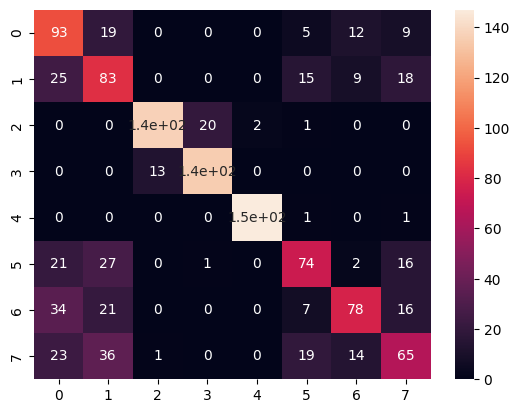

In [19]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [20]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred)
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [21]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, KNN_time]
results_dict["kNN"] = results

In [22]:
pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
kNN,0.676667,0.688459,0.676746,0.676667,0.632677,1.23,6.293333,2.508652,0.113561


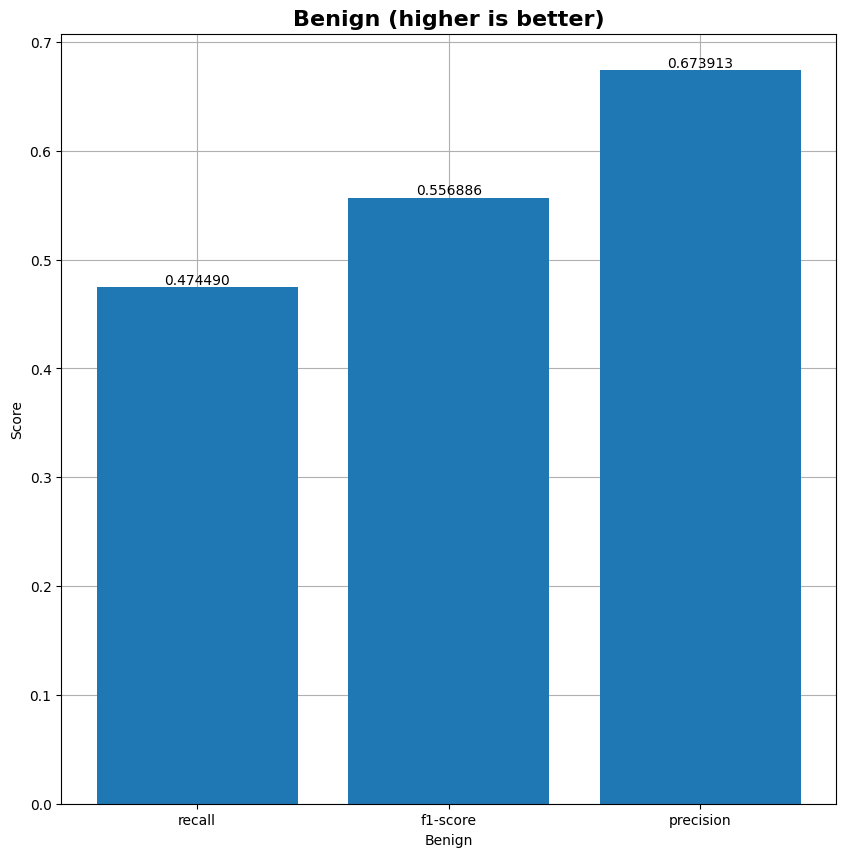

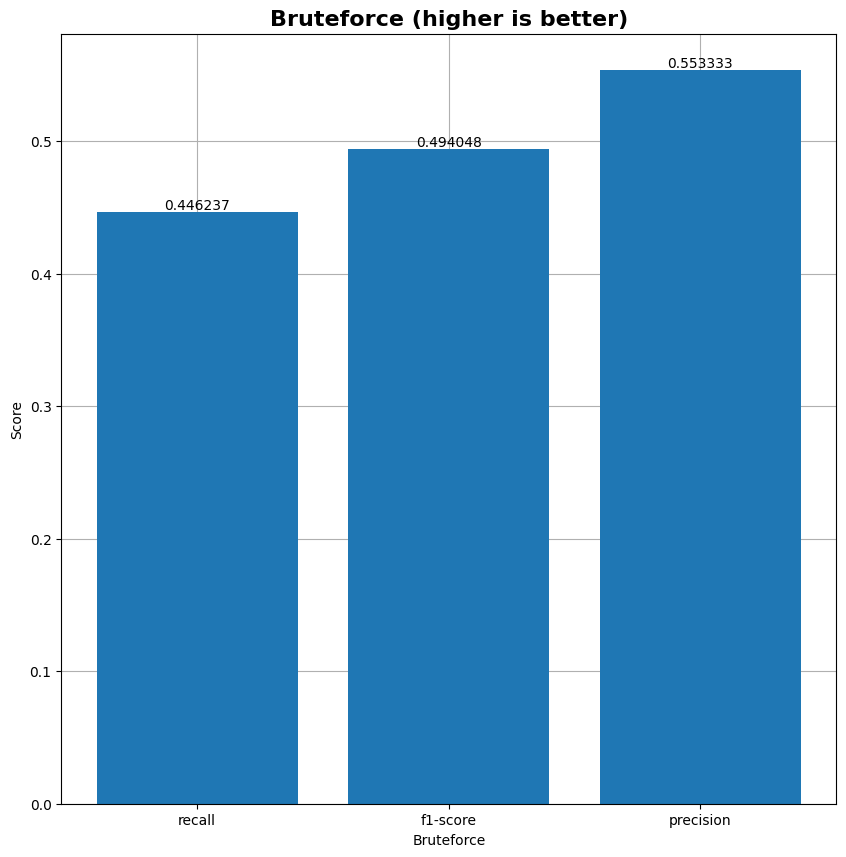

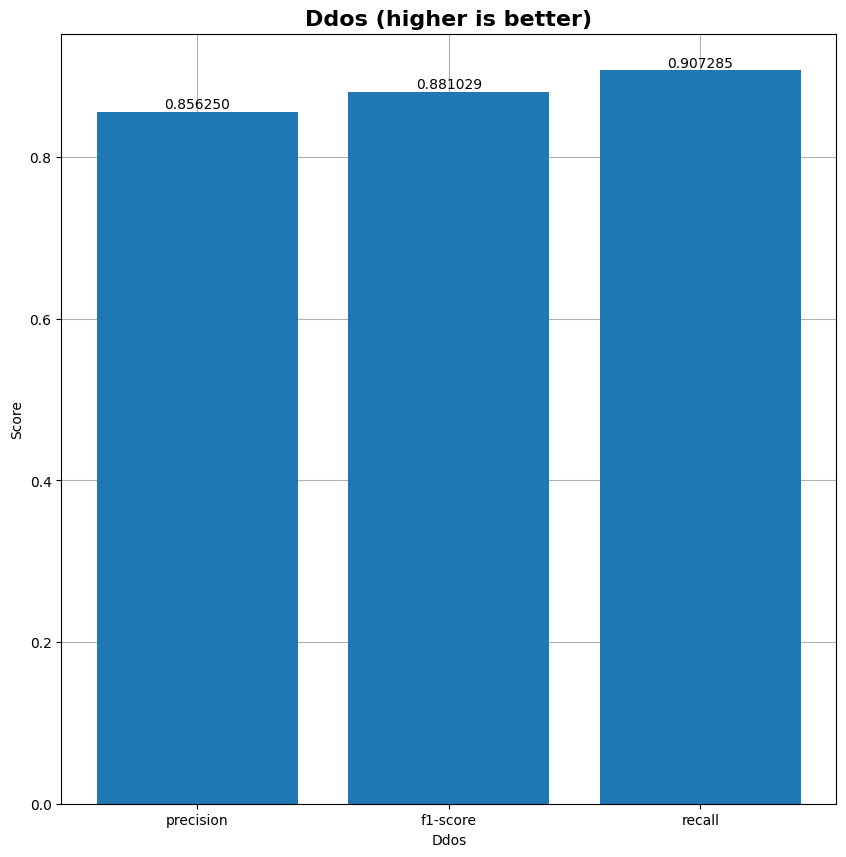

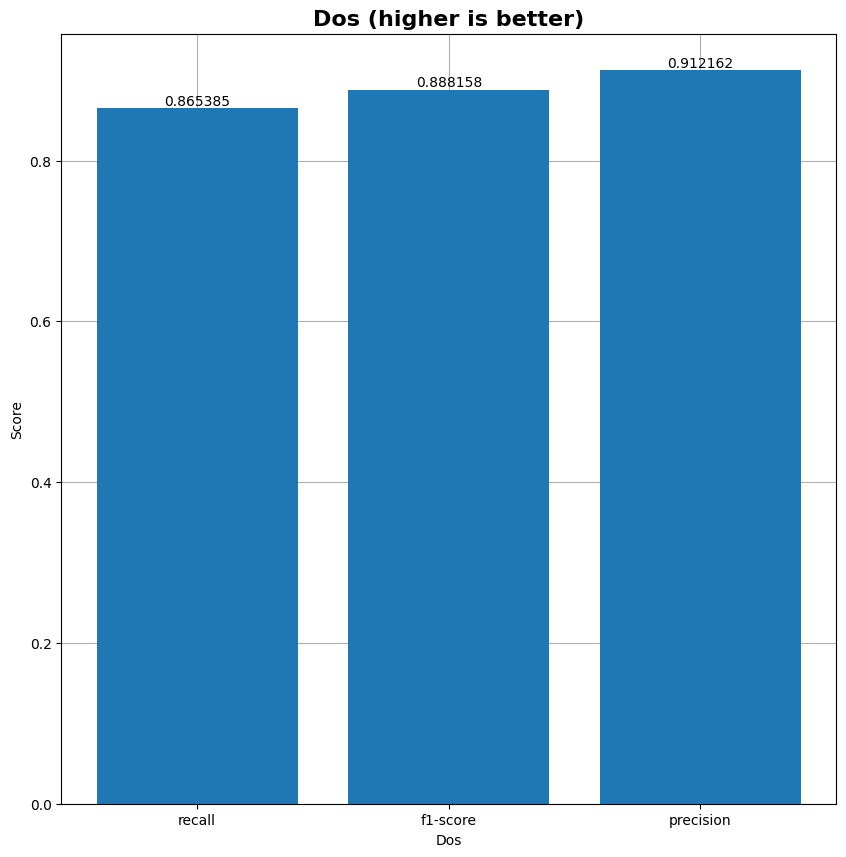

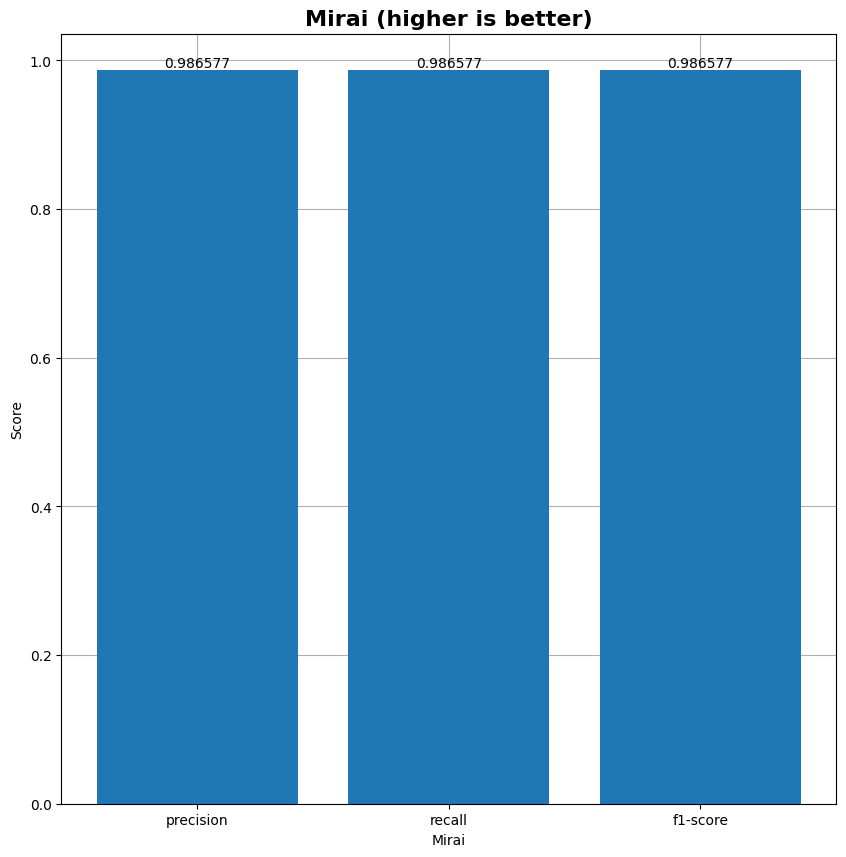

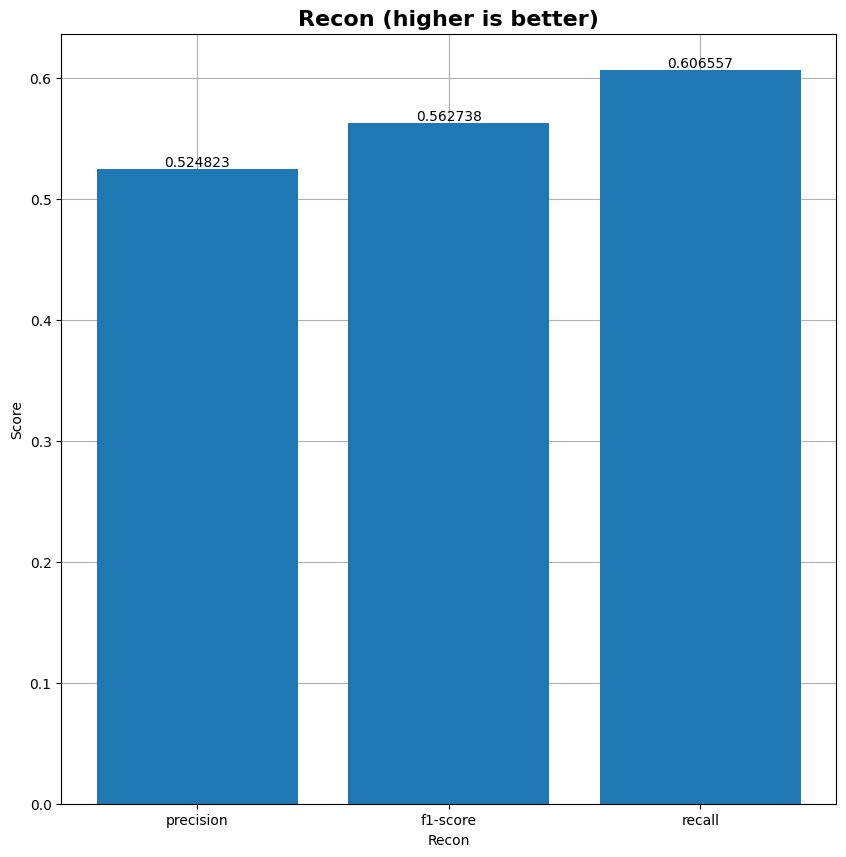

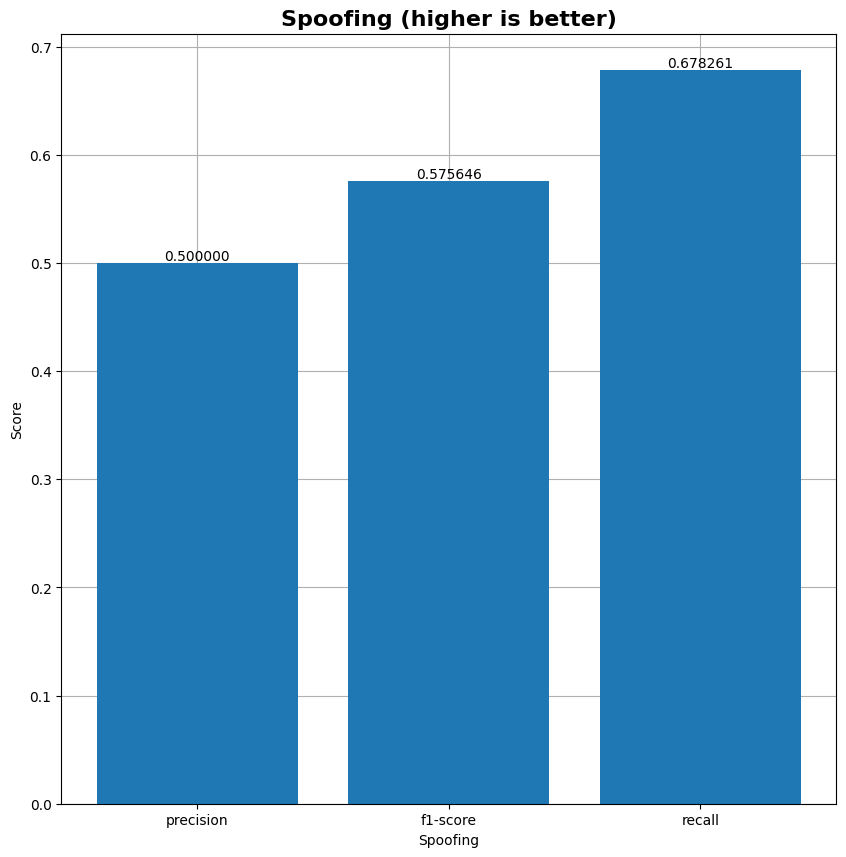

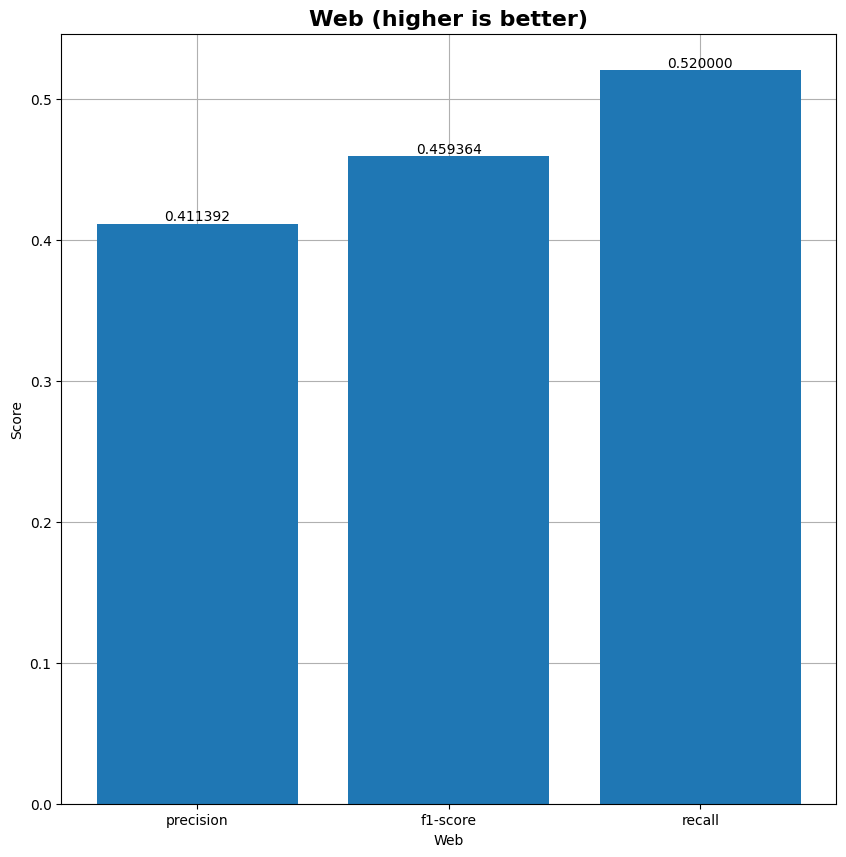

In [23]:
plot_mc(y_pred, y_test, "kNN")

# Random Forest

In [30]:
%%time

start = time.time()

rf_clf = RandomForestClassifier(n_jobs=8)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)

end = time.time()

RF_time = end - start

CPU times: user 2 s, sys: 38.1 ms, total: 2.04 s
Wall time: 383 ms


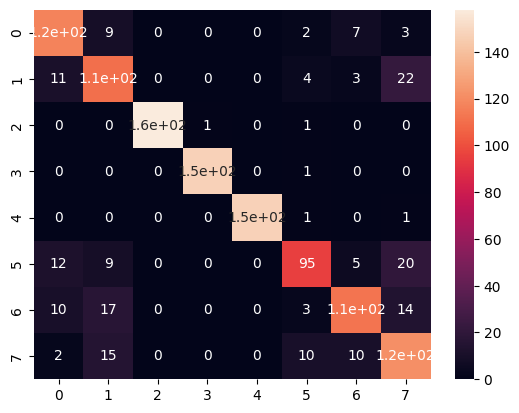

In [31]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [32]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred)
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [33]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, RF_time]
results_dict["RF"] = results

In [34]:
pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
kNN,0.676667,0.688459,0.676746,0.676667,0.632677,1.230000,6.293333,2.508652,0.113561
LR,0.620000,0.629409,0.619878,0.620000,0.566893,1.365000,6.818333,2.611194,6.539364
RF,0.839167,0.844161,0.839734,0.839167,0.816687,0.585833,2.869167,1.693861,0.382939


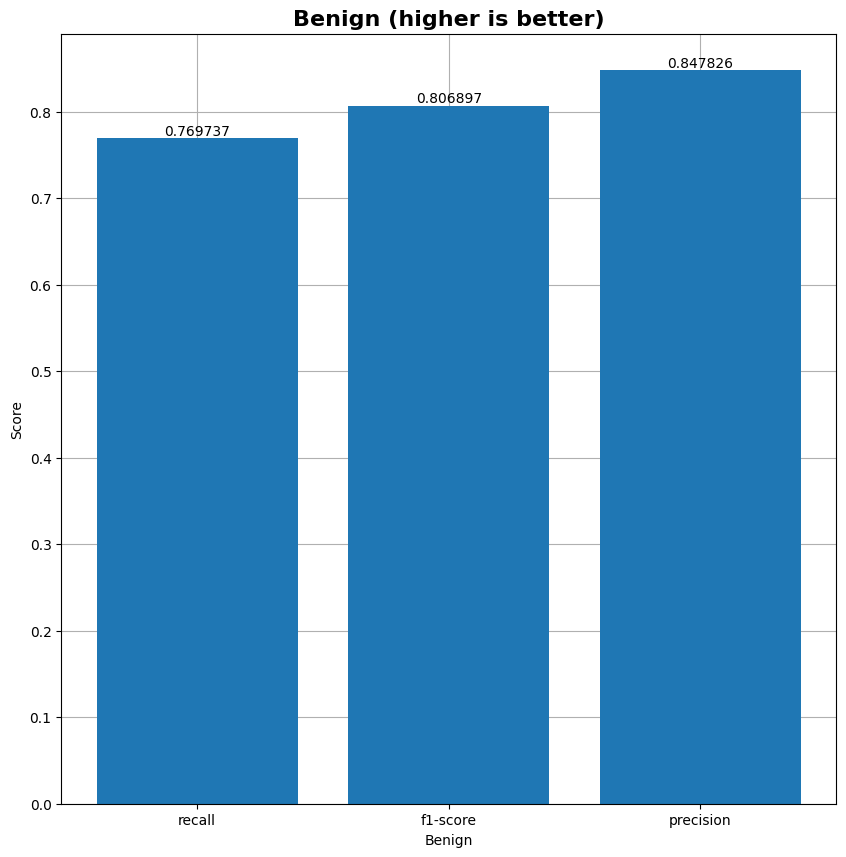

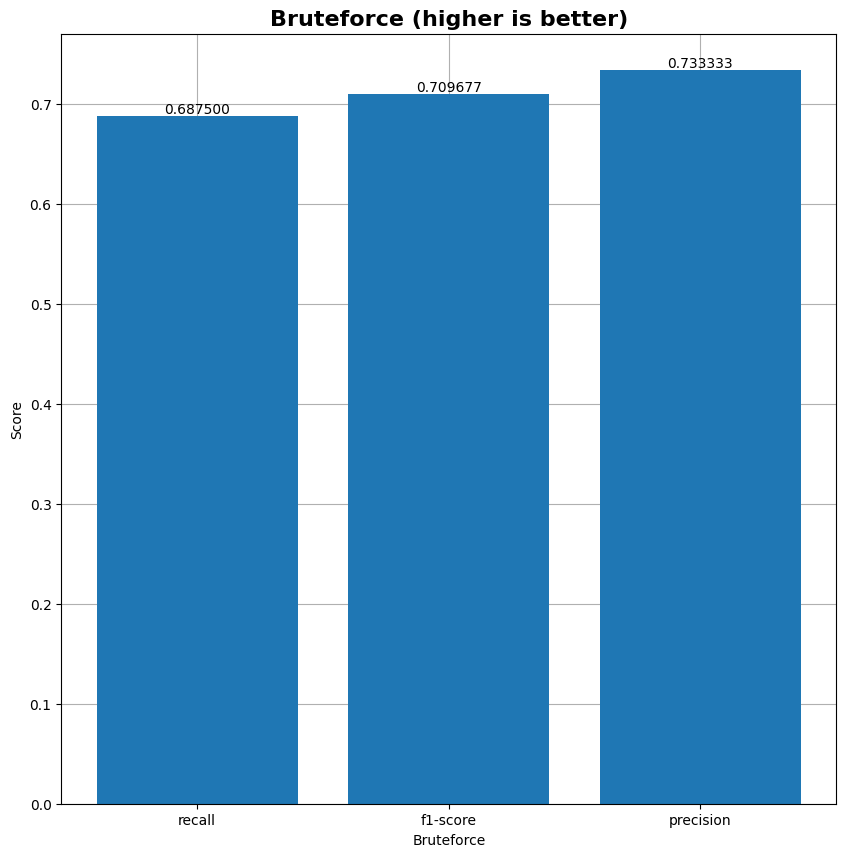

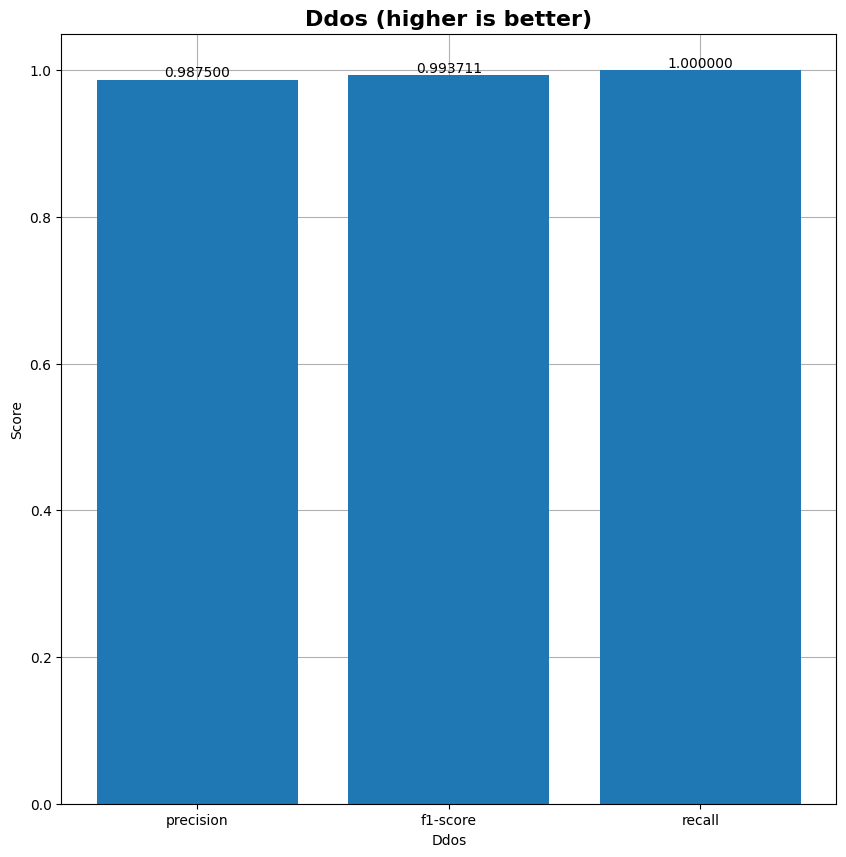

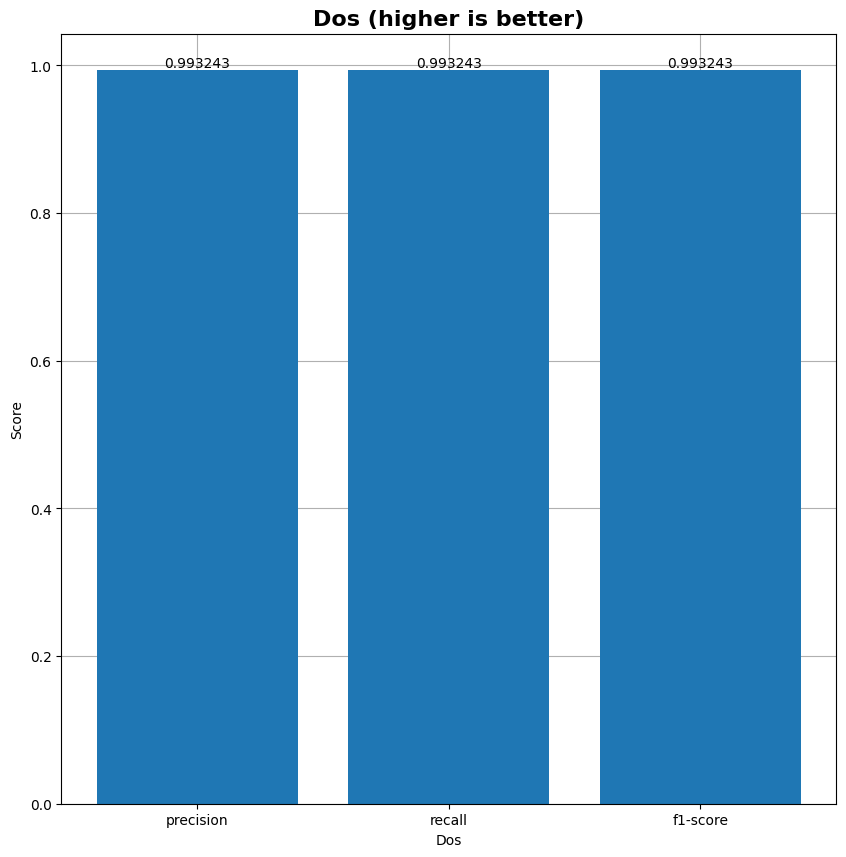

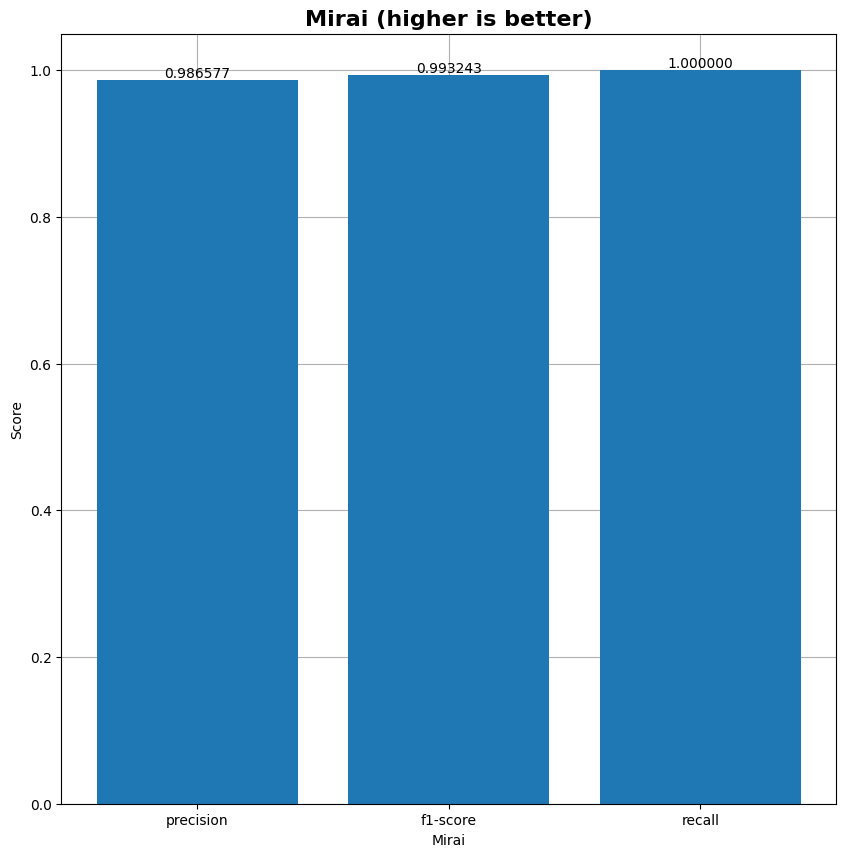

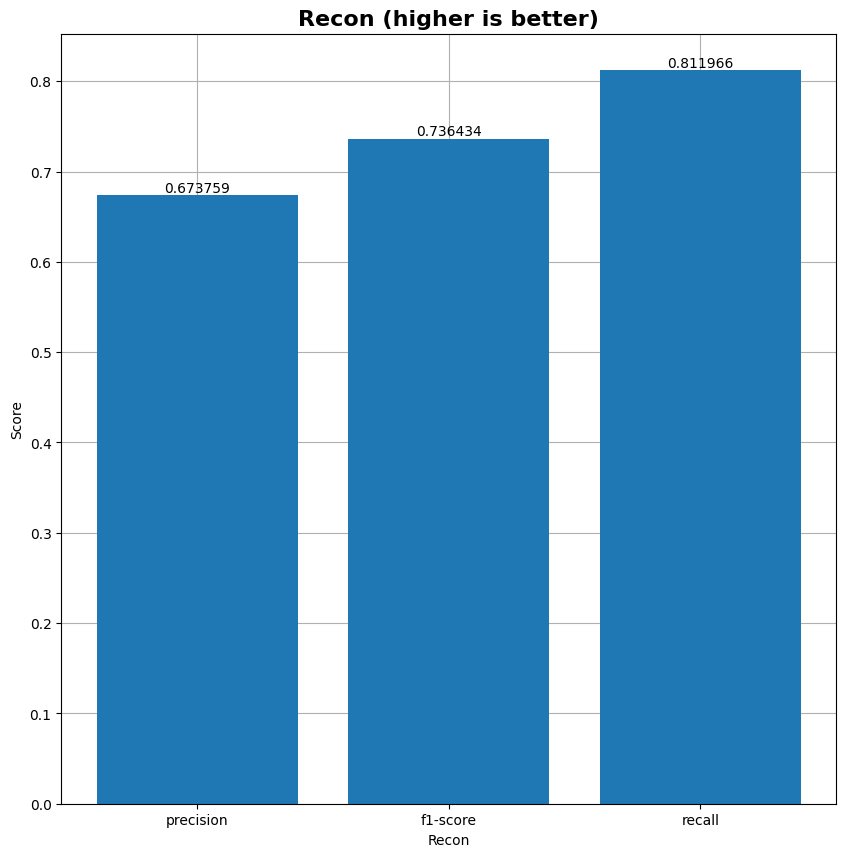

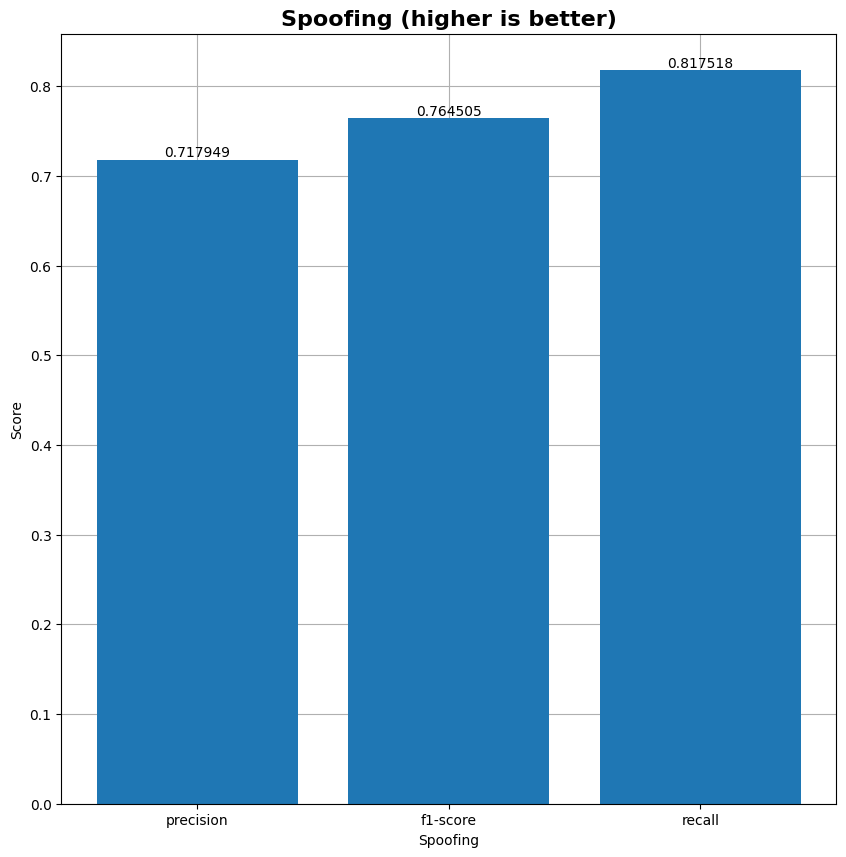

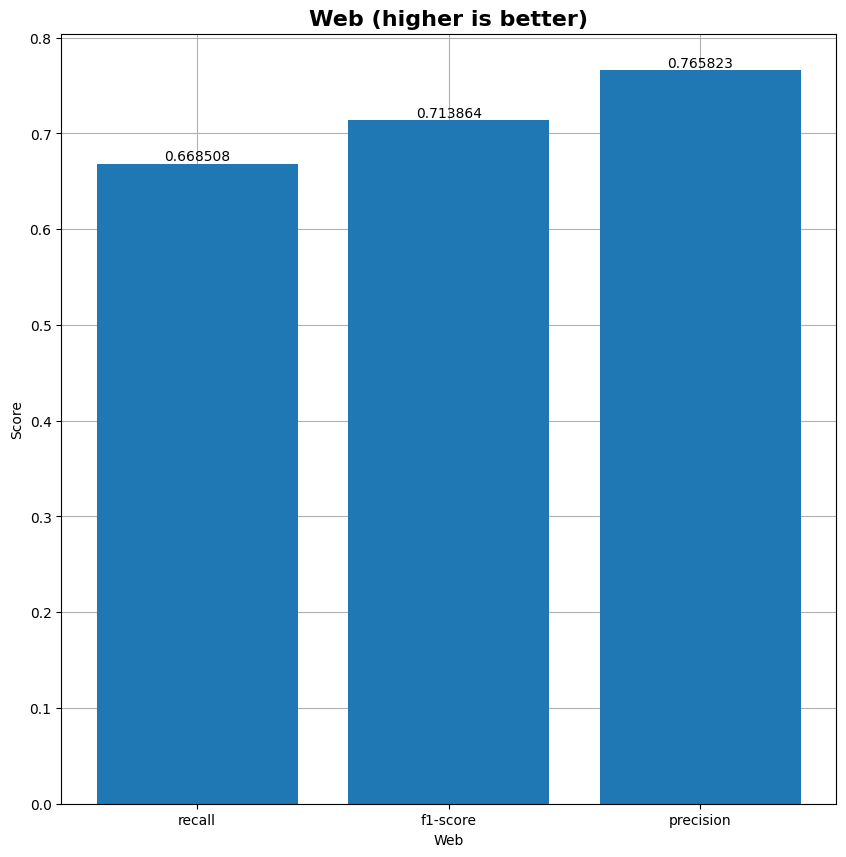

In [35]:
plot_mc(y_pred, y_test, "RF")

# XGBoost

In [37]:
%%time

start = time.time()

xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)

end = time.time()

XGB_time = end - start

CPU times: user 13.4 s, sys: 125 ms, total: 13.5 s
Wall time: 2.06 s


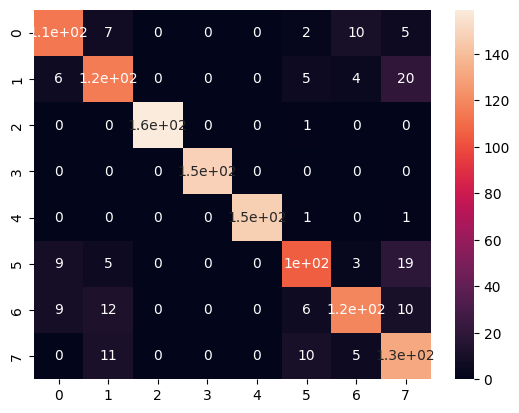

In [38]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [39]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [40]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, XGB_time]
results_dict["XGBoost"] = results

In [41]:
pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
kNN,0.676667,0.688459,0.676746,0.676667,0.632677,1.230000,6.293333,2.508652,0.113561
LR,0.620000,0.629409,0.619878,0.620000,0.566893,1.365000,6.818333,2.611194,6.539364
RF,0.839167,0.844161,0.839734,0.839167,0.816687,0.585833,2.869167,1.693861,0.382939
XGBoost,0.865833,0.869228,0.866390,0.865833,0.846987,0.510000,2.543333,1.594783,2.064113


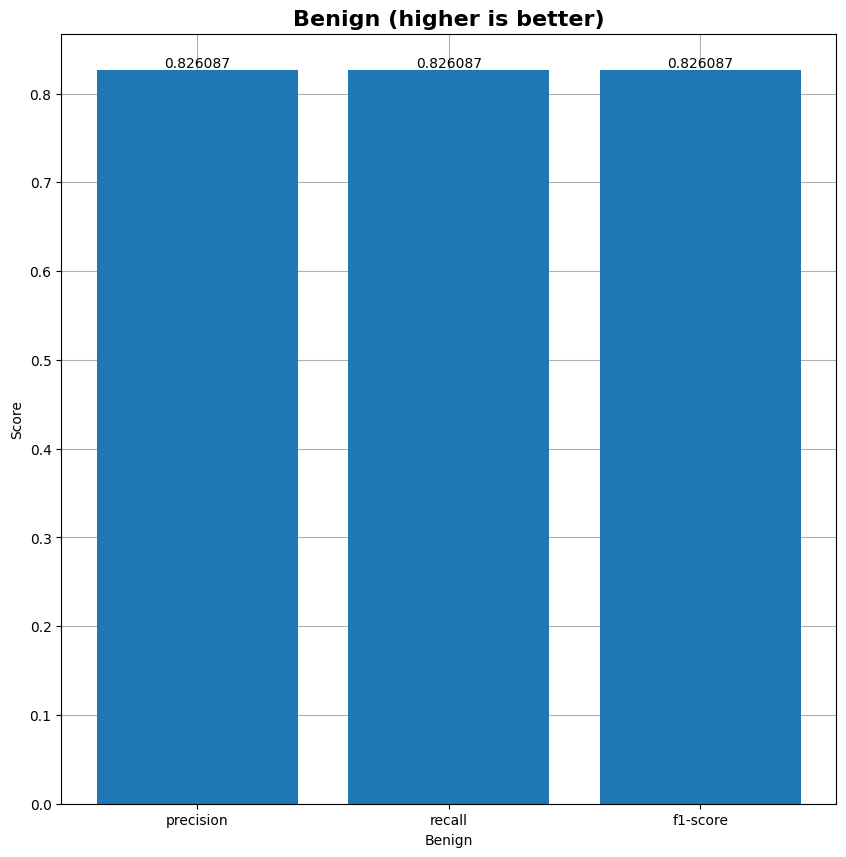

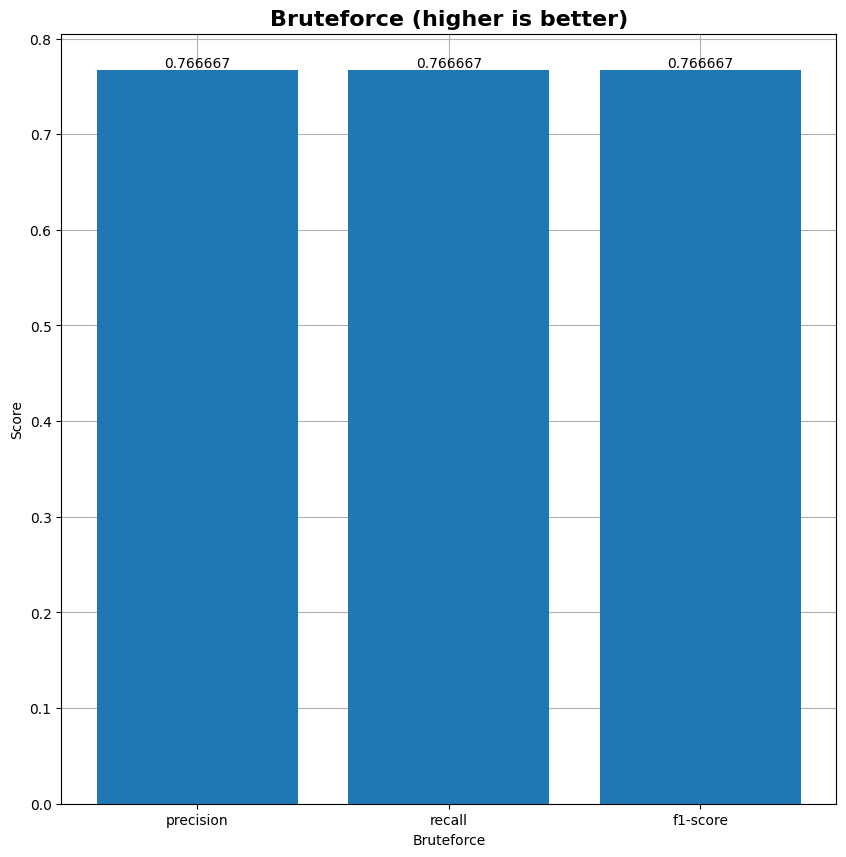

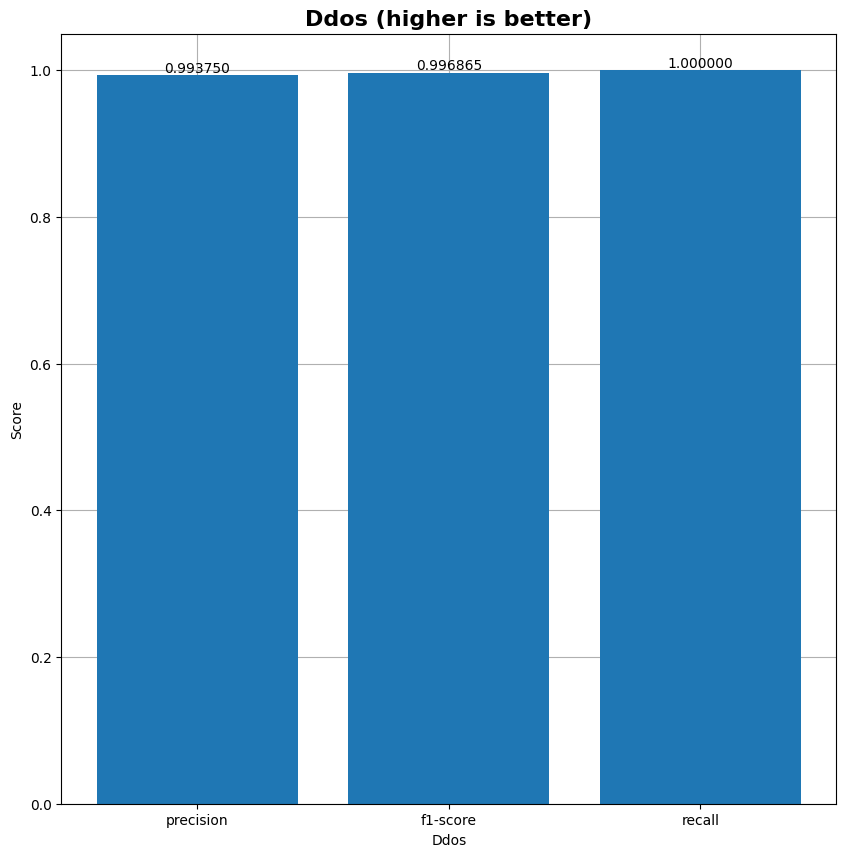

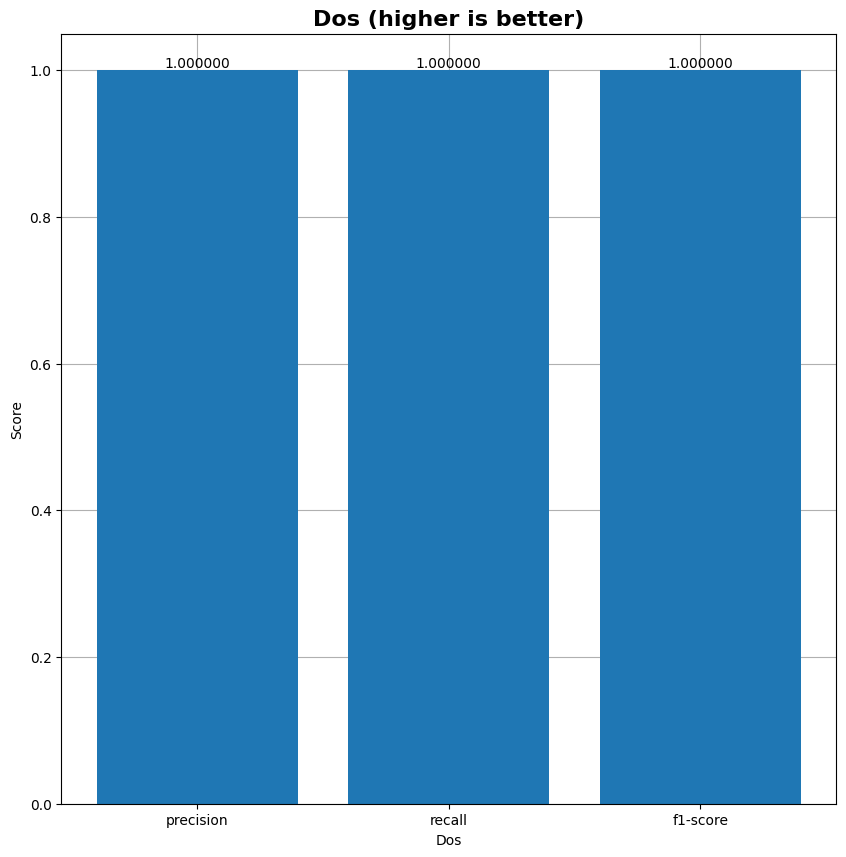

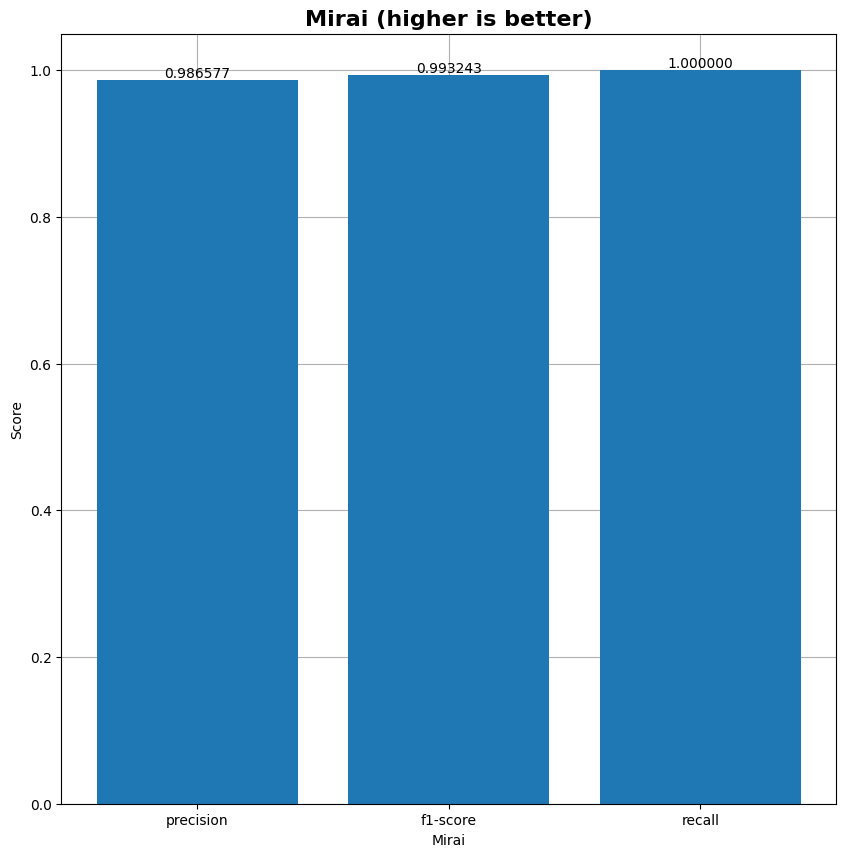

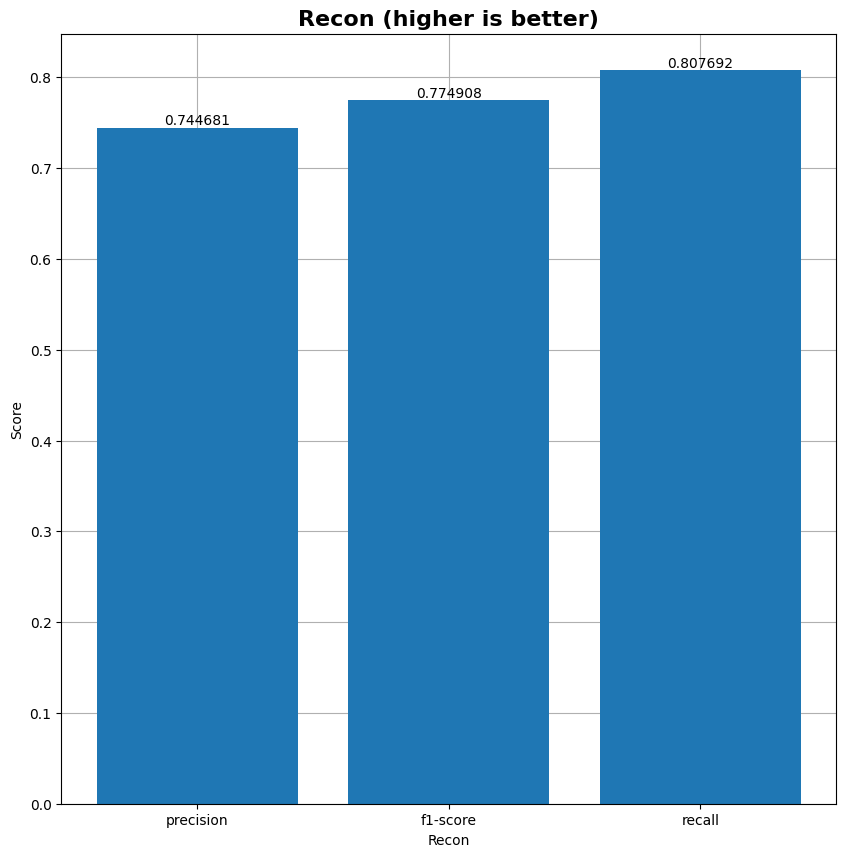

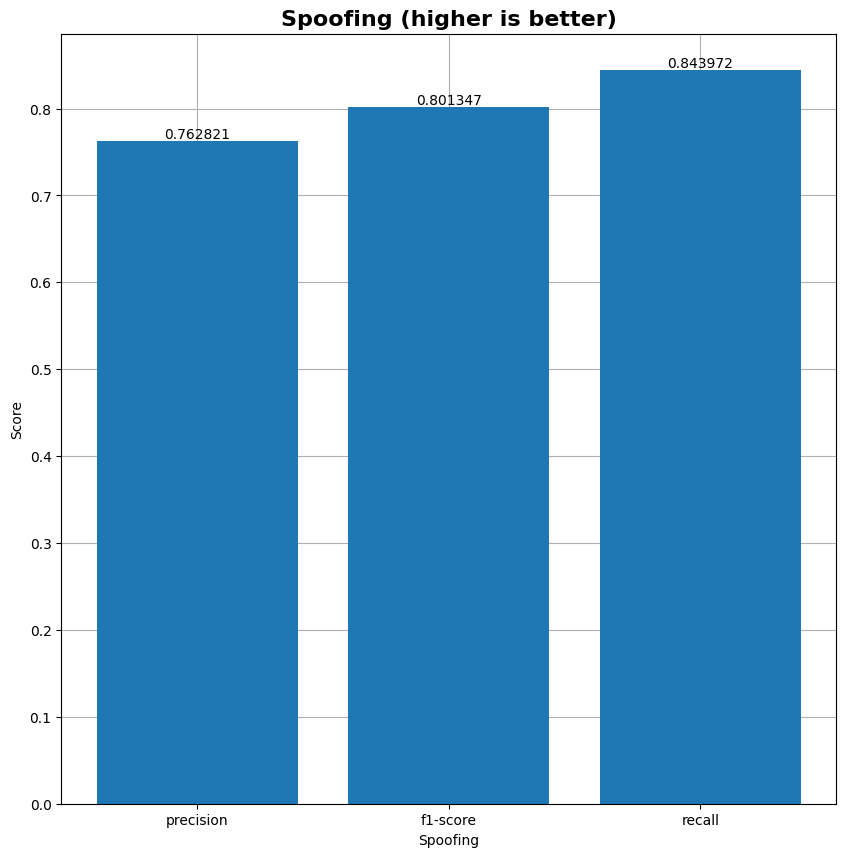

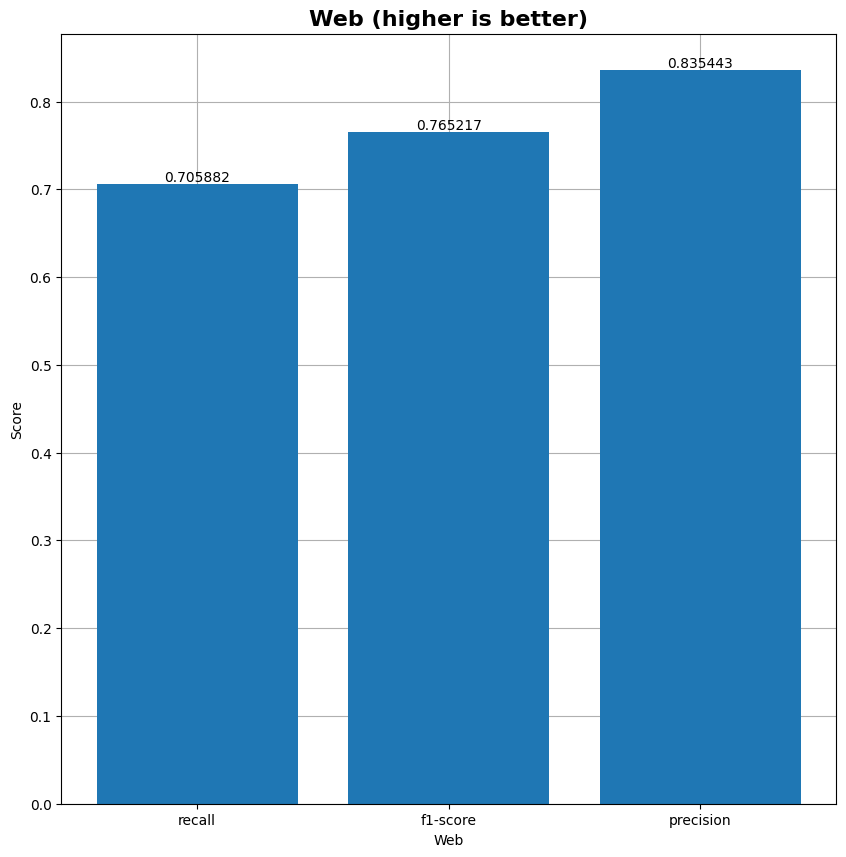

In [42]:
plot_mc(y_pred, y_test, "XGBoost")

# LightGBM

In [43]:
%%time

start = time.time()

lgbm_clf = lightgbm.LGBMClassifier()
lgbm_clf.fit(X_train, y_train)
y_pred = lgbm_clf.predict(X_test)

end = time.time()

LightGBM_Time = end - start

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4831
[LightGBM] [Info] Number of data points in the train set: 6800, number of used features: 35
[LightGBM] [Info] Start training from score -2.065423
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.091276
[LightGBM] [Info] Start training from score -2.077091
[LightGBM] [Info] Start training from score -2.078266
[LightGBM] [Info] Start training from score -2.068909
[LightGBM] [Info] Start training from score -2.086525
[LightGBM] [Info] Start training from score -2.088898
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/home/kostas/Documents/git/Magistrinis/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


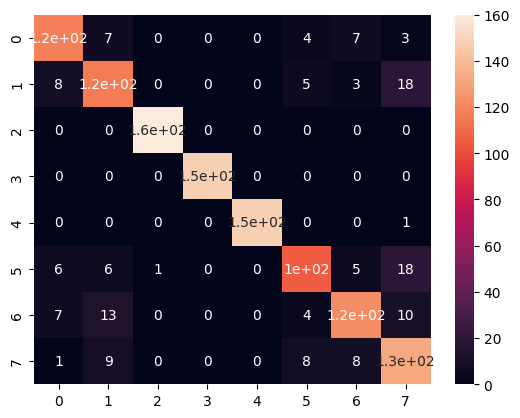

In [44]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [45]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [46]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, LightGBM_Time]
results_dict["LightGBM"] = results

In [47]:
pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
kNN,0.676667,0.688459,0.676746,0.676667,0.632677,1.230000,6.293333,2.508652,0.113561
LR,0.620000,0.629409,0.619878,0.620000,0.566893,1.365000,6.818333,2.611194,6.539364
RF,0.839167,0.844161,0.839734,0.839167,0.816687,0.585833,2.869167,1.693861,0.382939
XGBoost,0.865833,0.869228,0.866390,0.865833,0.846987,0.510000,2.543333,1.594783,2.064113
LightGBM,0.873333,0.875621,0.873527,0.873333,0.855473,0.456667,2.218333,1.489407,1.438659


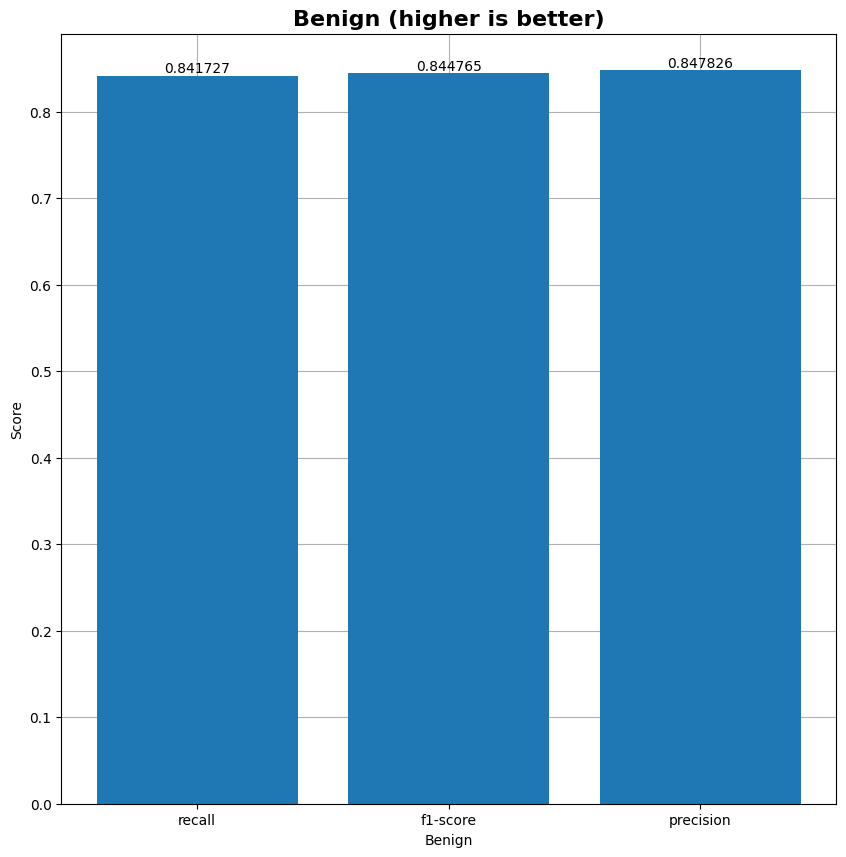

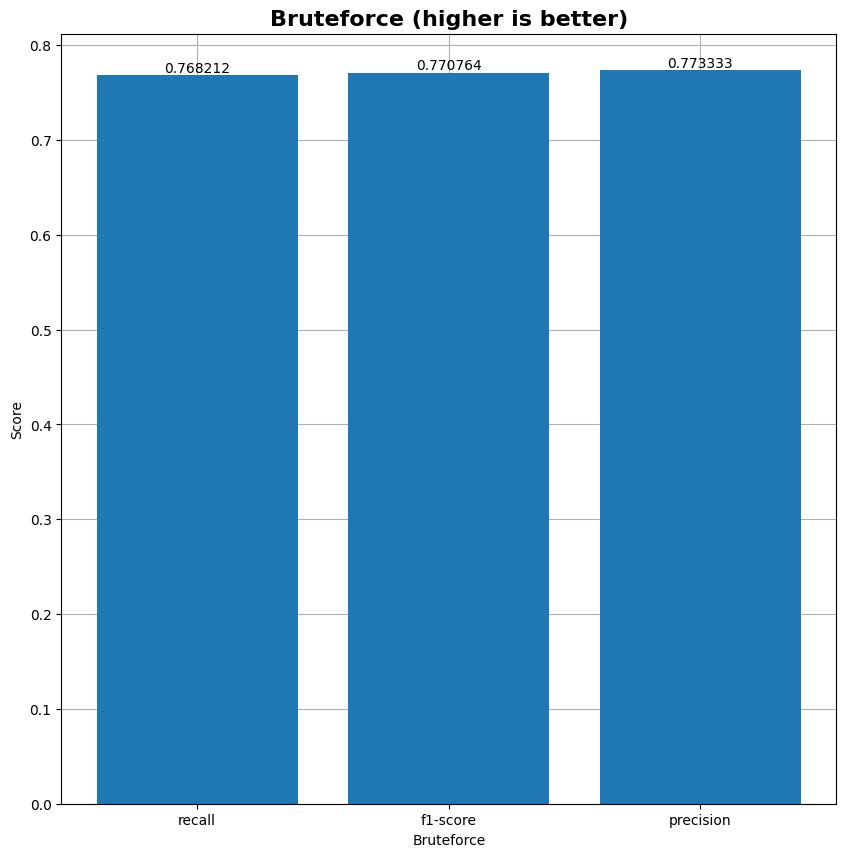

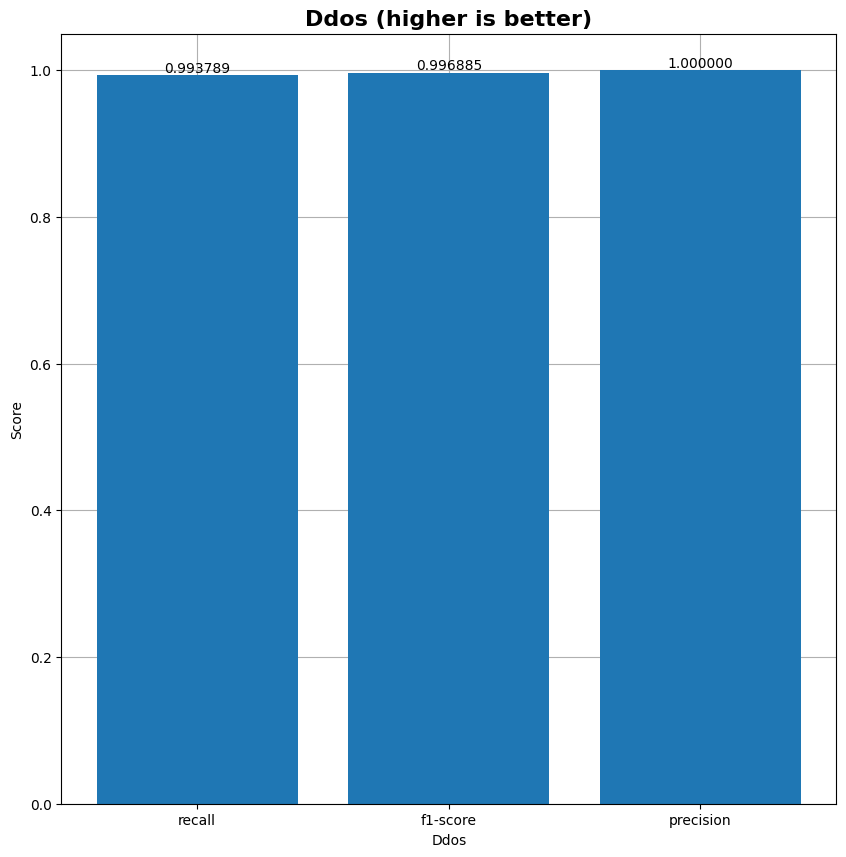

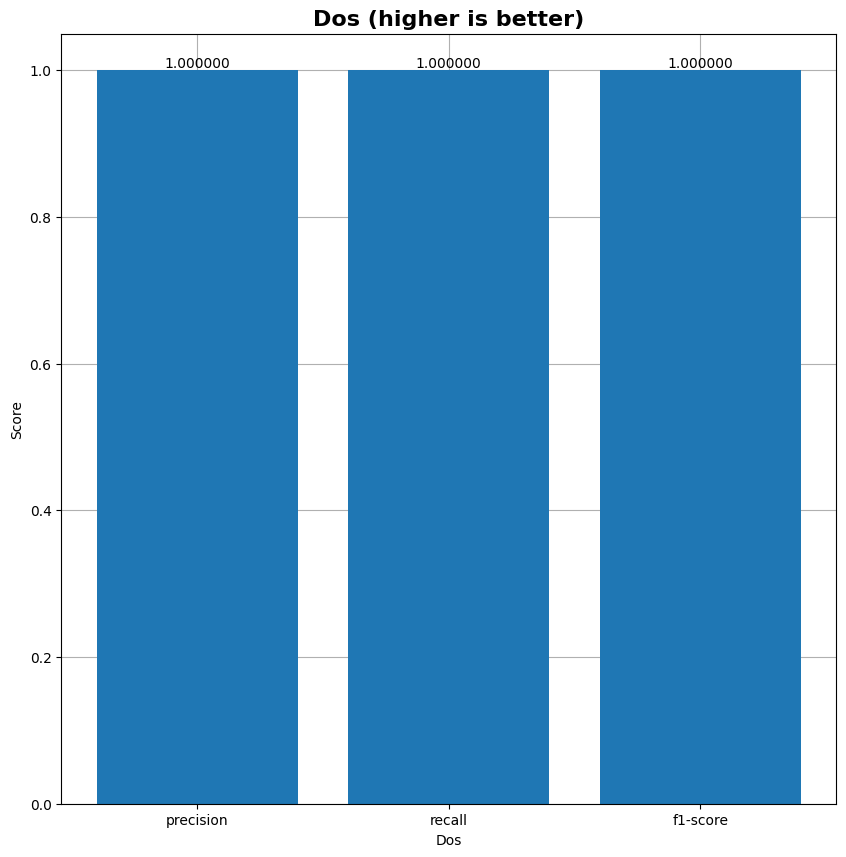

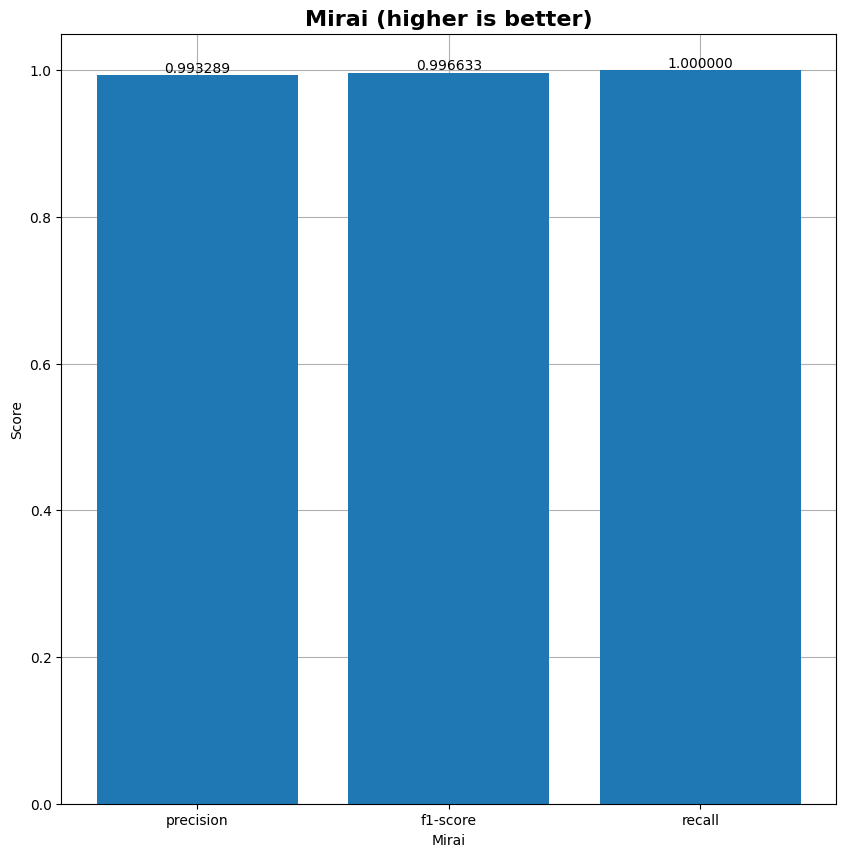

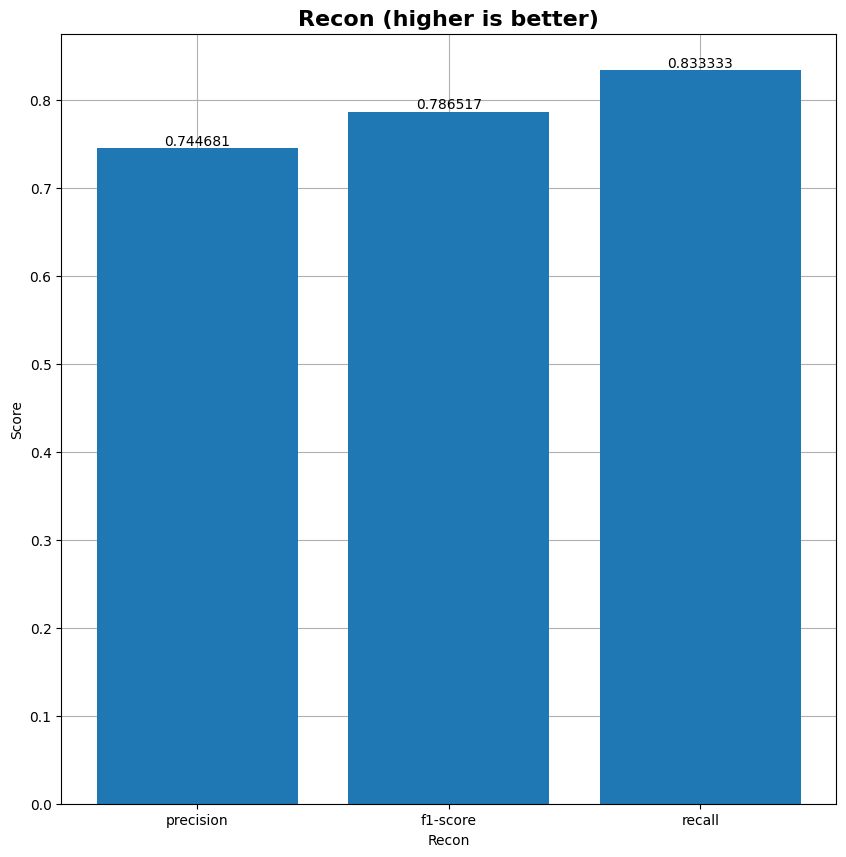

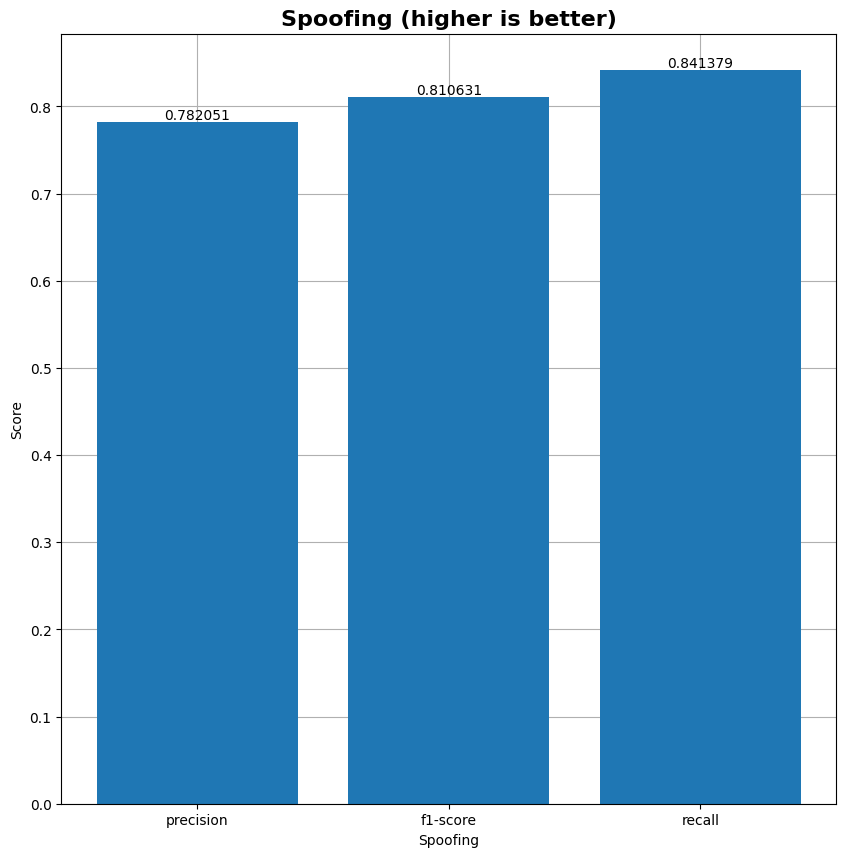

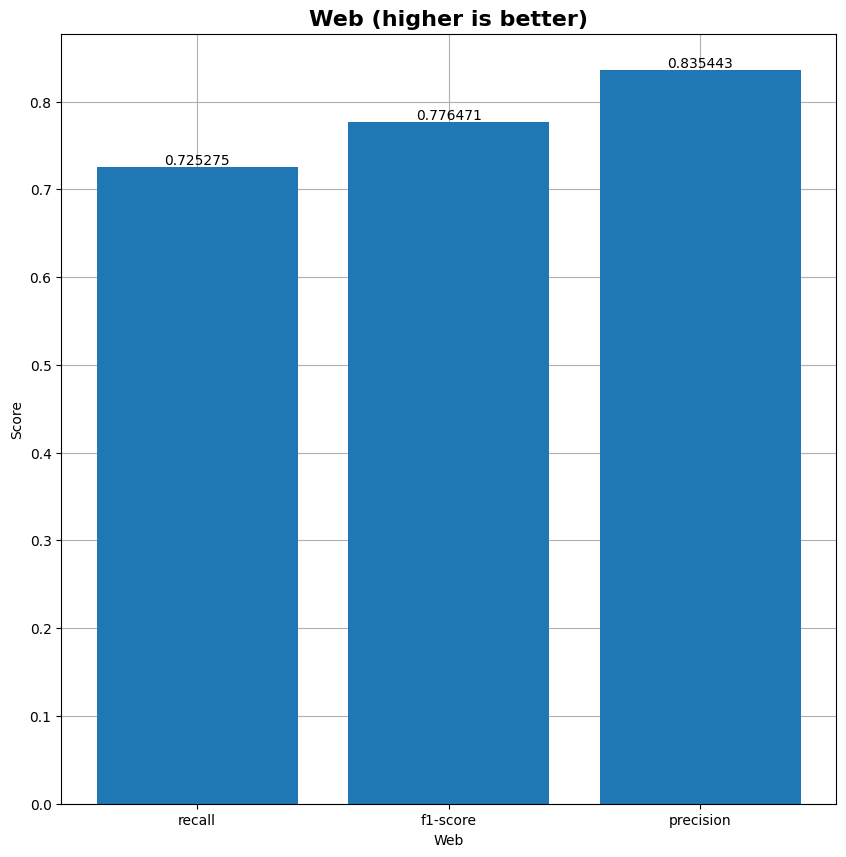

In [48]:
plot_mc(y_pred, y_test, "LightGBM")

# Feed Forward Neural Network

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.18)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((5576, 46), (5576,), (1224, 46), (1224,), (1200, 46), (1200,))

In [56]:
def create_model(X_train, y_train):
    model = keras.Sequential()
    model.add(keras.layers.Dense(X_train.shape[1], activation='relu', input_shape=(X_train.shape[1],)))
    model.add(keras.layers.Dense(1024, activation='relu'))
    model.add(keras.layers.Dense(512, activation='relu'))
    model.add(keras.layers.Dense(len(np.unique(y_train)), activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model
model = create_model(X_train, y_train)

/home/kostas/Documents/git/Magistrinis/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
W0000 00:00:1744117975.479935   58514 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [57]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 46)             │         2,162 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │        48,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 579,194 (2.21 MB)

 Trainable params: 579,194 (2.21 MB)

 Non-trainable params: 0 (0.00 B)

In [58]:
%%time

start = time.time()

model.fit(X_train, y_train,
          batch_size=16,
          epochs=20,
          validation_data=(X_val, y_val))
gc.collect();

y_pred = model.predict(X_test)

end = time.time()

FFNN_Time = end - start

Epoch 1/100
349/349 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5246 - loss: 1.2137 - val_accuracy: 0.6275 - val_loss: 0.8960
Epoch 2/100
349/349 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6237 - loss: 0.8735 - val_accuracy: 0.6422 - val_loss: 0.8827
Epoch 3/100
349/349 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6617 - loss: 0.8007 - val_accuracy: 0.6283 - val_loss: 0.9014
Epoch 4/100
349/349 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6802 - loss: 0.7561 - val_accuracy: 0.6536 - val_loss: 0.8414
Epoch 5/100
349/349 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6944 - loss: 0.7375 - val_accuracy: 0.6552 - val_loss: 0.8315
Epoch 6/100
349/349 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7032 - loss: 0.7075 - val_accuracy: 0.6471 - val_loss: 0.8258
Epoch 7/100
349/349 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6931 - loss: 0.7236 - val_accuracy: 0.6601 - val_loss: 0.8140
Epoch 8/100
349/349 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7097 - loss: 0.6727 - val_accu

In [59]:
y_pred = np.argmax(y_pred, axis=1)

In [60]:
_, accuracy = model.evaluate(X_test, y_test)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6692 - loss: 2.7101 


In [61]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, FFNN_Time]
results_dict["FF-NN"] = results

In [62]:
pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
kNN,0.676667,0.688459,0.676746,0.676667,0.632677,1.230000,6.293333,2.508652,0.113561
LR,0.620000,0.629409,0.619878,0.620000,0.566893,1.365000,6.818333,2.611194,6.539364
RF,0.839167,0.844161,0.839734,0.839167,0.816687,0.585833,2.869167,1.693861,0.382939
XGBoost,0.865833,0.869228,0.866390,0.865833,0.846987,0.510000,2.543333,1.594783,2.064113
LightGBM,0.873333,0.875621,0.873527,0.873333,0.855473,0.456667,2.218333,1.489407,1.438659
SVM,0.634167,0.717894,0.629410,0.634167,0.596632,1.305000,6.761667,2.600320,9.117928
FF-NN,0.672500,0.682991,0.670667,0.672500,0.627214,1.168333,5.855000,2.419711,222.915646


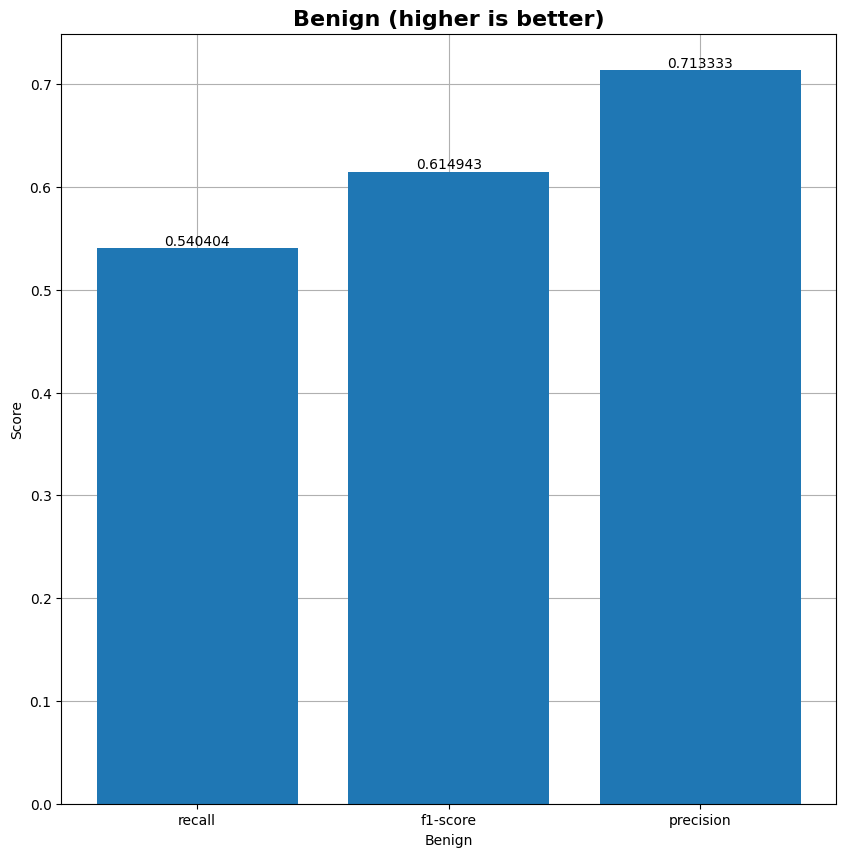

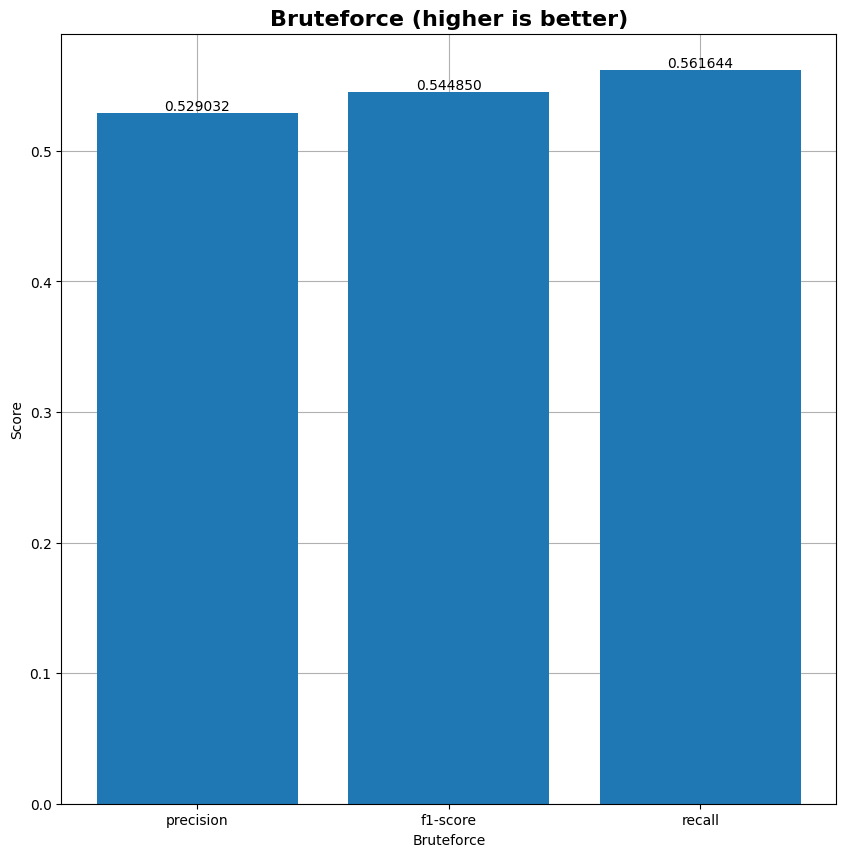

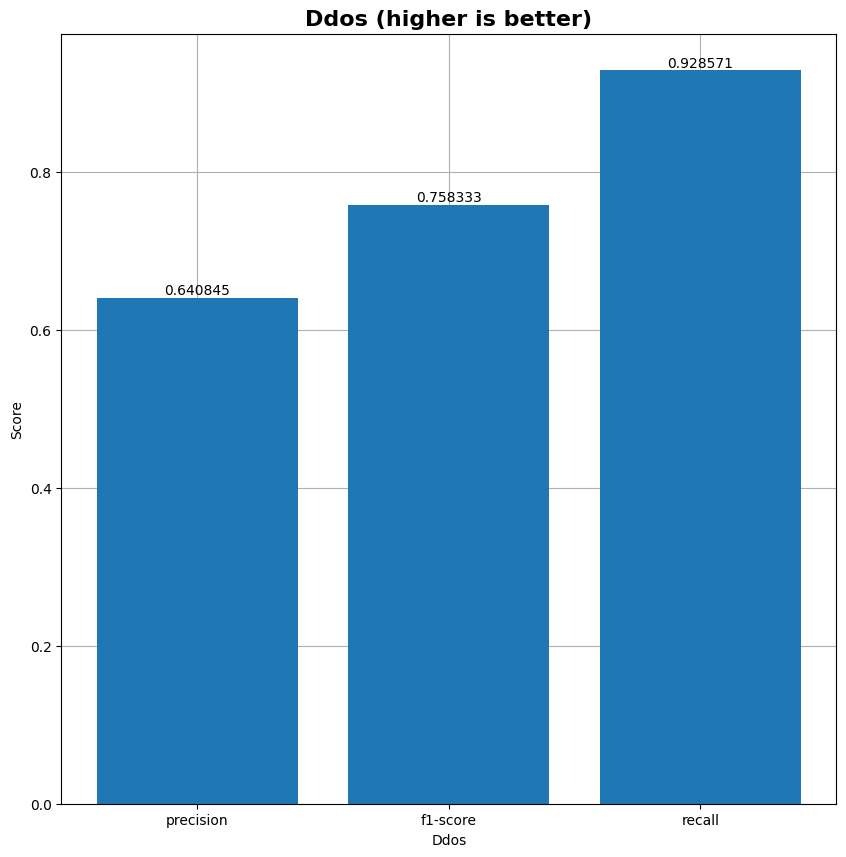

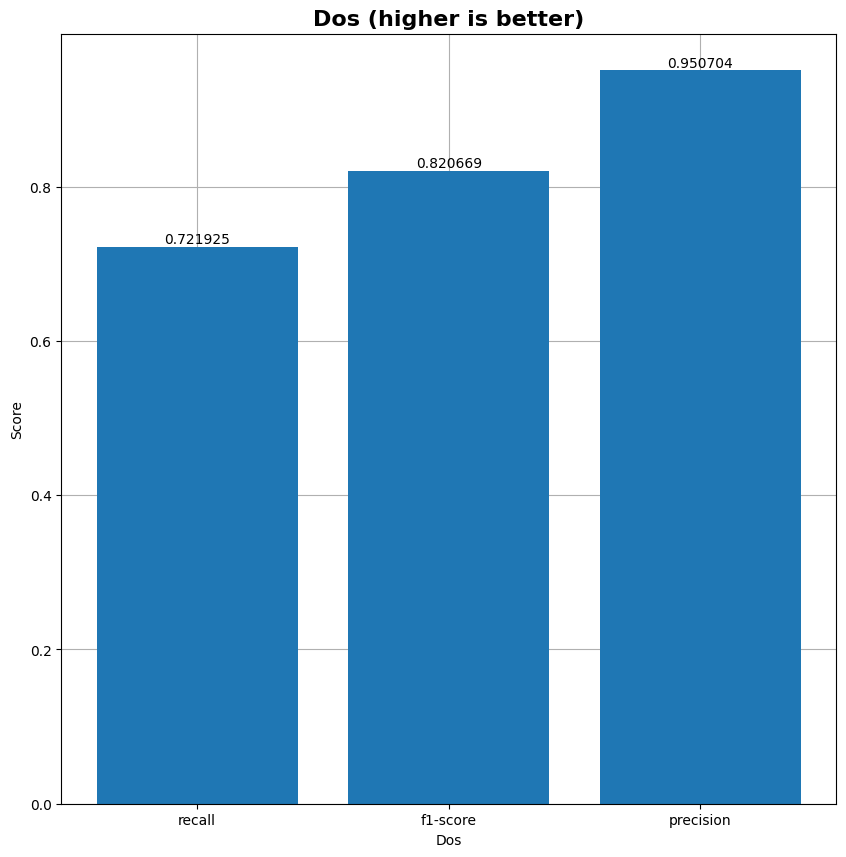

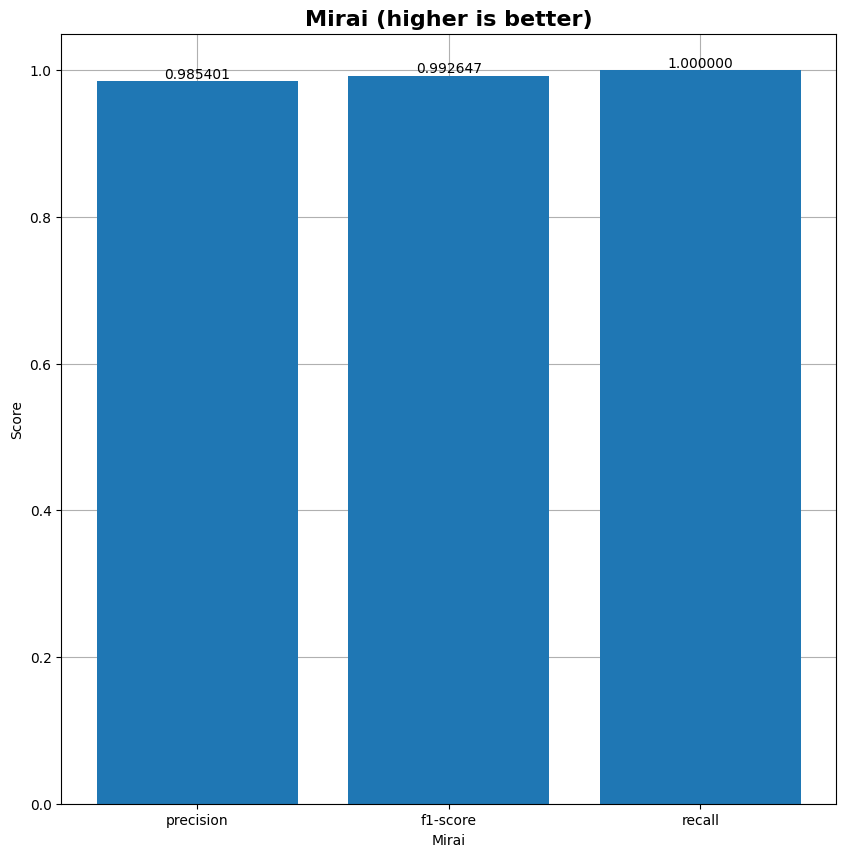

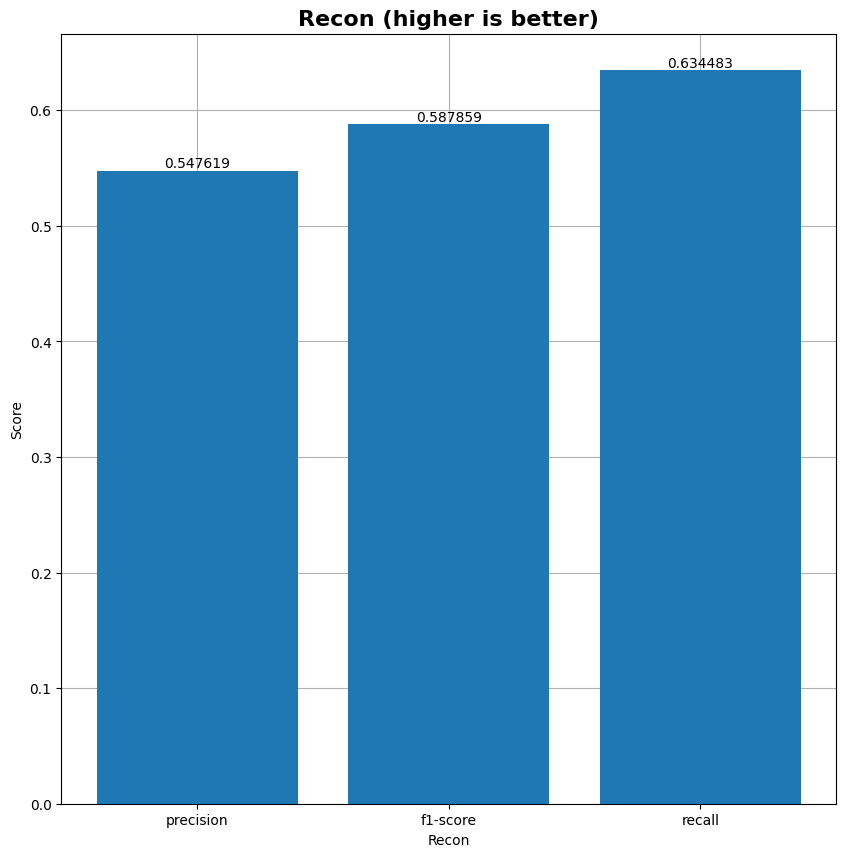

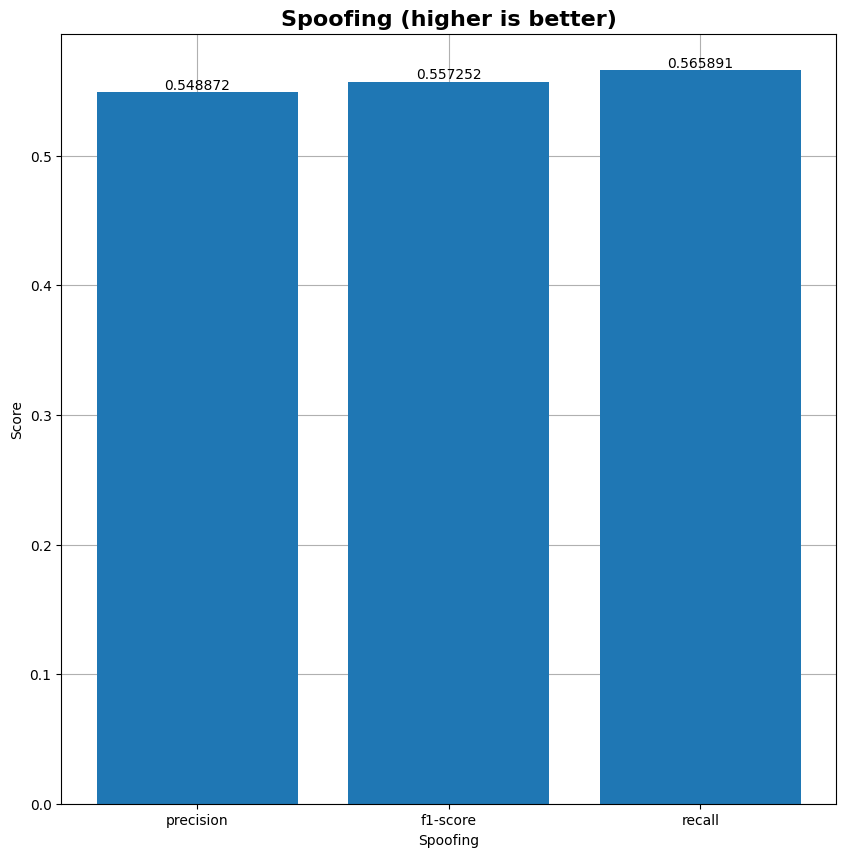

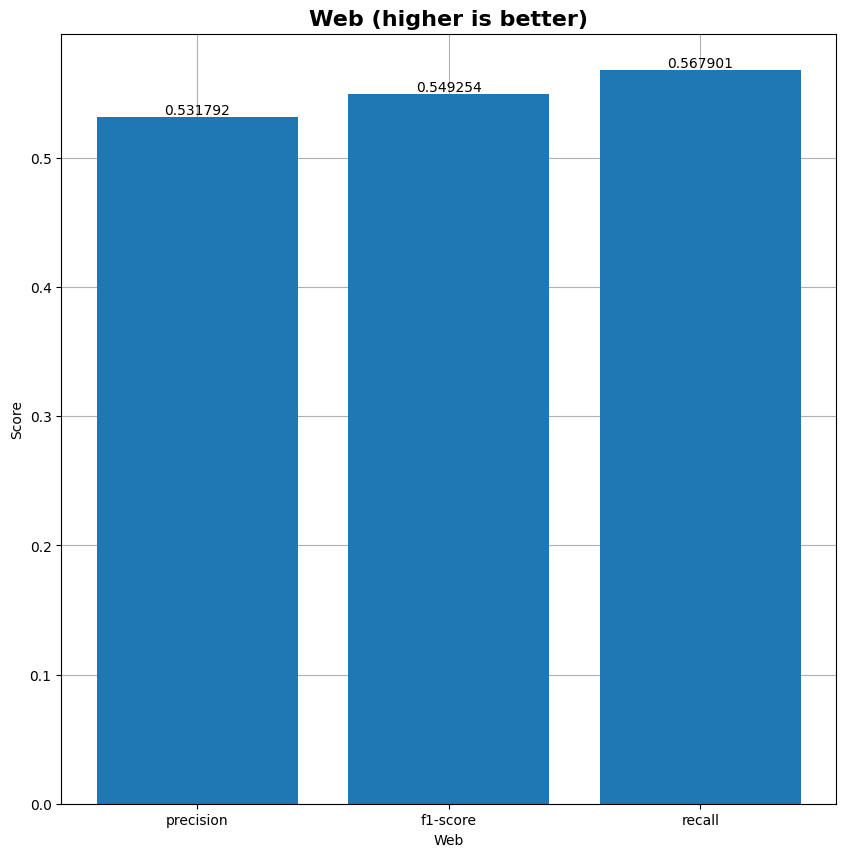

In [63]:
plot_mc(y_pred, y_test, "FF-NN")

# LSTM

In [64]:
# Prepare sequential data
def create_sequences(features, labels, seq_length):
    sequences, seq_labels = [], []
    for i in range(len(features) - seq_length):
        sequences.append(features[i:i + seq_length])
        seq_labels.append(labels[i + seq_length - 1])  # Use the last label in the sequence
    return np.array(sequences), np.array(seq_labels)

In [65]:
num_components = len(np.unique(y))

In [66]:
# Create sequences
seq_length = 20
X1, y1 = create_sequences(X, y, seq_length)
y1 = to_categorical(y1, num_classes=num_components)  # Convert labels to one-hot encoding

In [67]:
# Split data
X_train, X_temp, y_train, y_temp = train_test_split(X1, y1, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [68]:
def create_model_LSTM(input_shape, num_classes):
    model = keras.Sequential([
        keras.layers.LSTM(64, input_shape=input_shape, return_sequences=True),
        keras.layers.Dropout(0.3),
        keras.layers.LSTM(32),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(num_classes, activation='softmax')  # Use softmax for multi-class classification
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [69]:
# Build model
model = create_model_LSTM(input_shape=(seq_length, X1.shape[2]), num_classes=num_components)

/home/kostas/Documents/git/Magistrinis/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [70]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 64)         │        28,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,464 (169.78 KB)

 Trainable params: 43,464 (169.78 KB)

 Non-trainable params: 0 (0.00 B)

In [71]:
%%time

start = time.time()

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val)
)

# Evaluate model
y_pred = model.predict(X_test)

end = time.time()

LSTM_Time = end - start

Epoch 1/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.6905 - loss: 1.0995 - val_accuracy: 0.9866 - val_loss: 0.0623
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9852 - loss: 0.0711 - val_accuracy: 0.9925 - val_loss: 0.0410
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9885 - loss: 0.0485 - val_accuracy: 0.9858 - val_loss: 0.0532
Epoch 4/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9948 - loss: 0.0282 - val_accuracy: 0.9950 - val_loss: 0.0335
Epoch 5/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9974 - loss: 0.0141 - val_accuracy: 0.9958 - val_loss: 0.0350
Epoch 6/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9972 - loss: 0.0116 - val_accuracy: 0.9950 - val_loss: 0.0332
Epoch 7/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9975 - loss: 0.0084 - val_accuracy: 0.9942 - val_loss: 0.0355
Epoch 8/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9967 - loss: 0.0110 - val_accu

In [72]:
_, accuracy = model.evaluate(X_test, y_test)

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9981 - loss: 0.0033     


In [73]:
y_test = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

In [74]:
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [75]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, LSTM_Time]
results_dict["LSTM"] = results

In [76]:
pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
kNN,0.676667,0.688459,0.676746,0.676667,0.632677,1.230000,6.293333,2.508652,0.113561
LR,0.620000,0.629409,0.619878,0.620000,0.566893,1.365000,6.818333,2.611194,6.539364
RF,0.839167,0.844161,0.839734,0.839167,0.816687,0.585833,2.869167,1.693861,0.382939
XGBoost,0.865833,0.869228,0.866390,0.865833,0.846987,0.510000,2.543333,1.594783,2.064113
LightGBM,0.873333,0.875621,0.873527,0.873333,0.855473,0.456667,2.218333,1.489407,1.438659
SVM,0.634167,0.717894,0.629410,0.634167,0.596632,1.305000,6.761667,2.600320,9.117928
FF-NN,0.672500,0.682991,0.670667,0.672500,0.627214,1.168333,5.855000,2.419711,222.915646
LSTM,0.996658,0.996692,0.996658,0.996658,0.996184,0.012531,0.064327,0.253629,23.837416


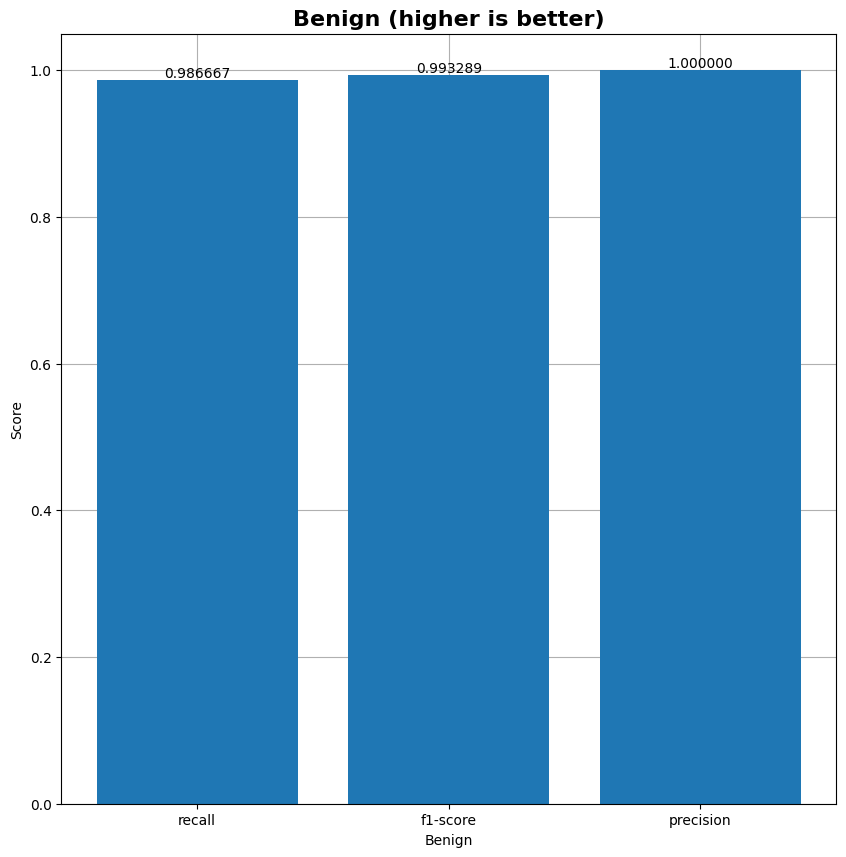

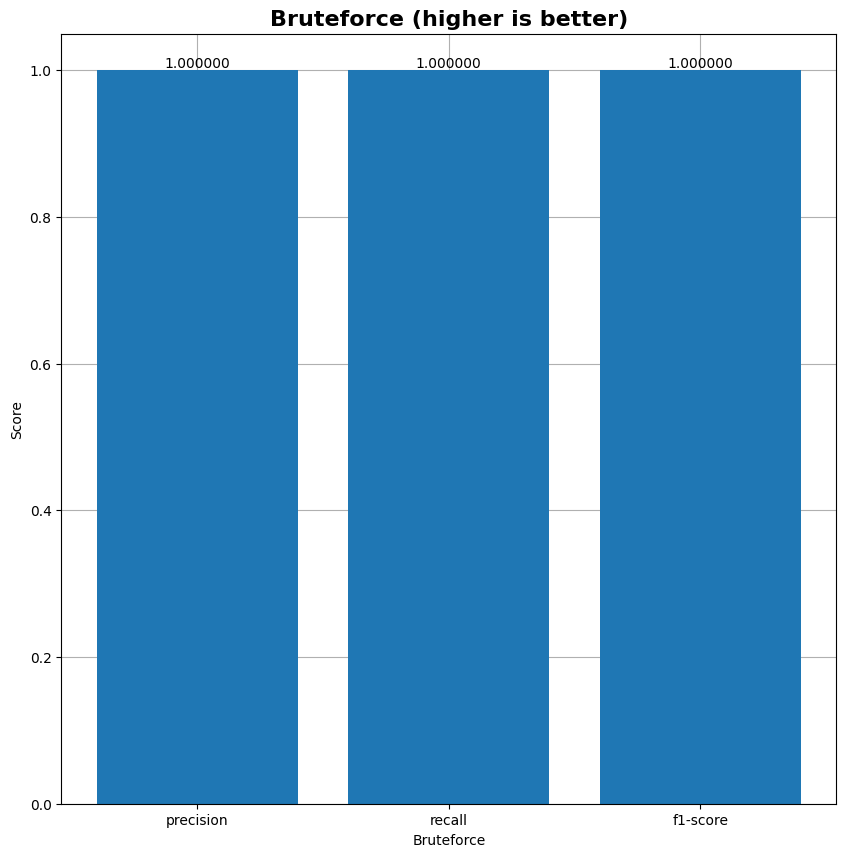

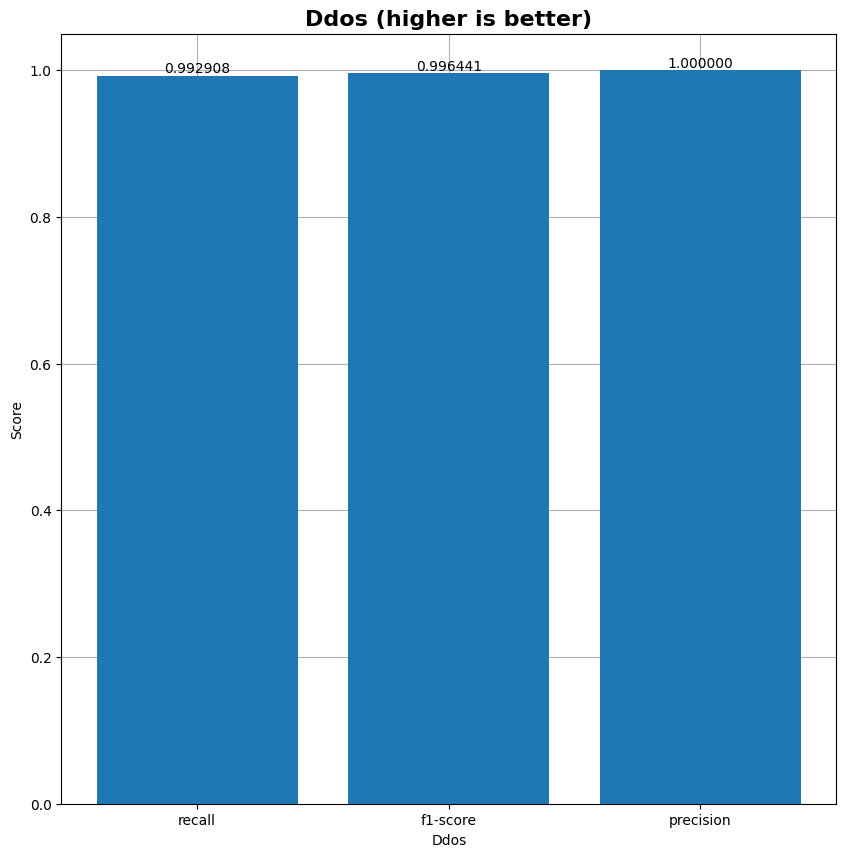

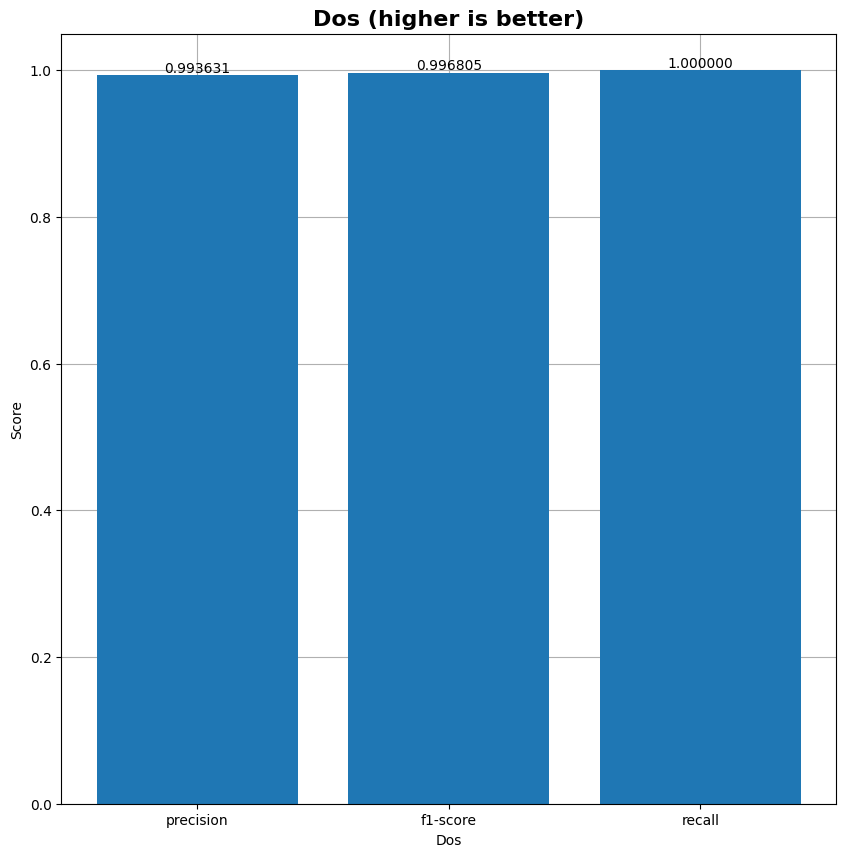

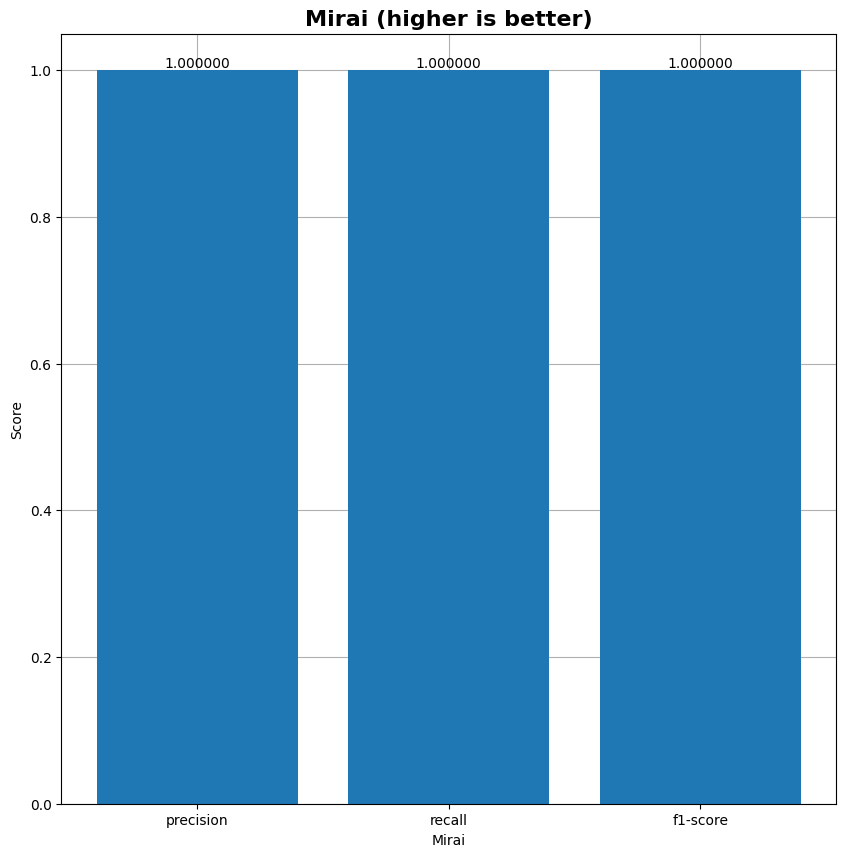

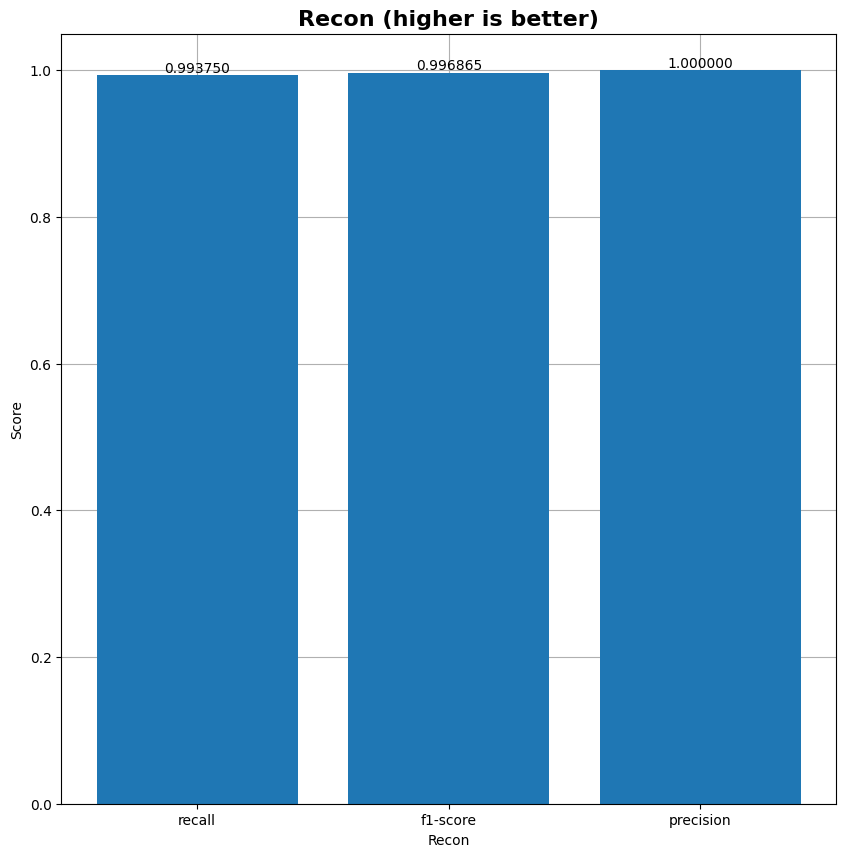

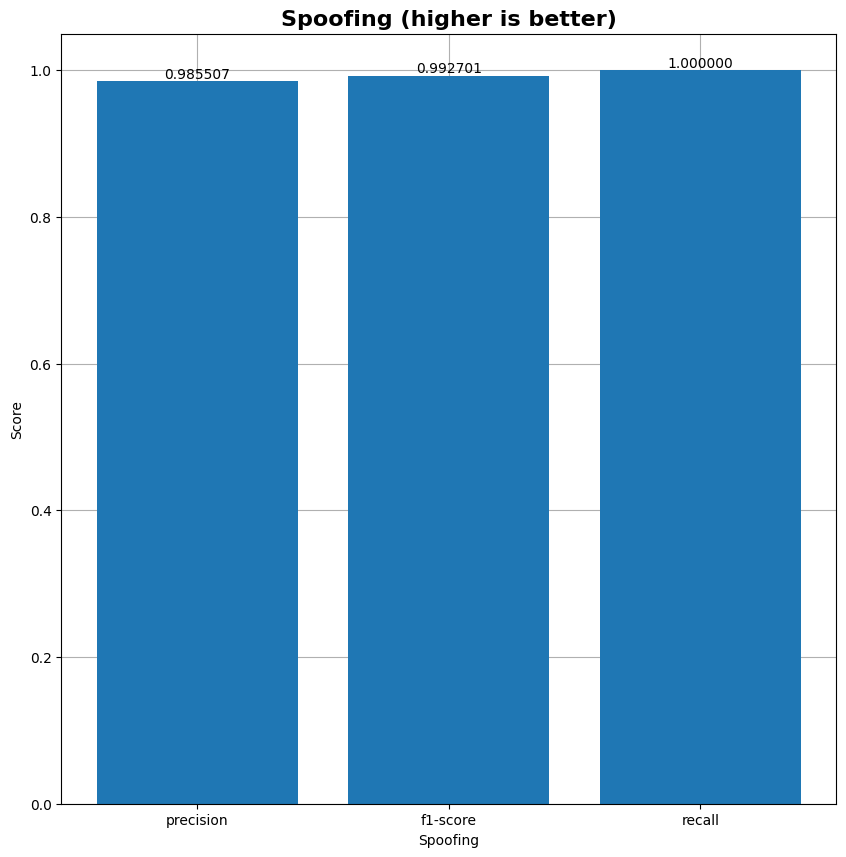

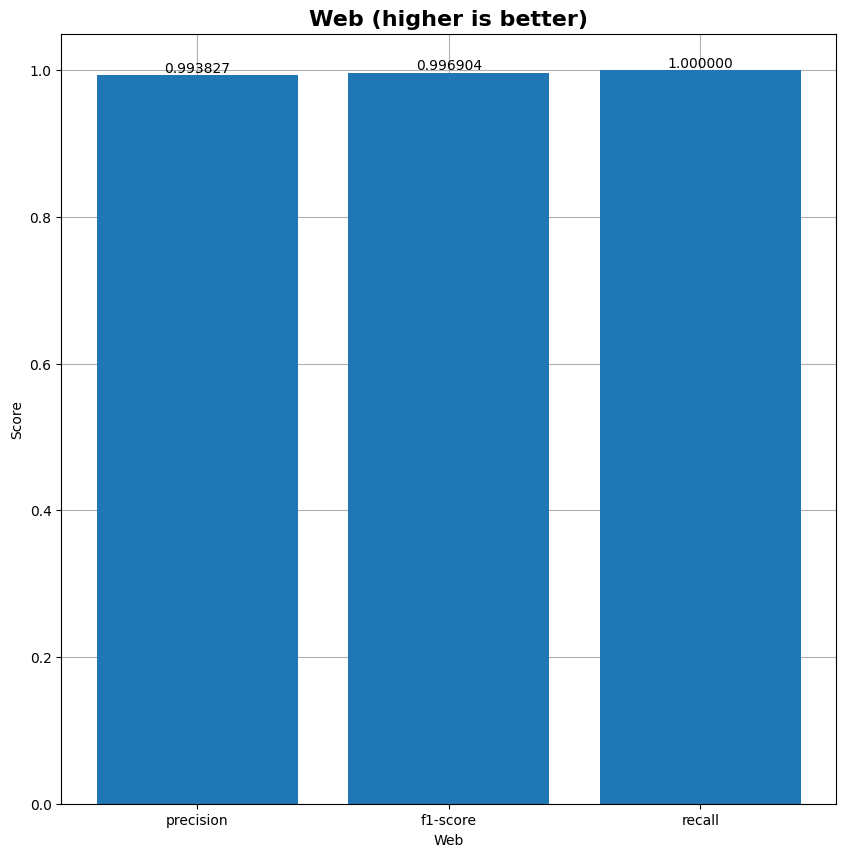

In [78]:
plot_mc(y_pred, y_test, "LSTM")

# Plot data

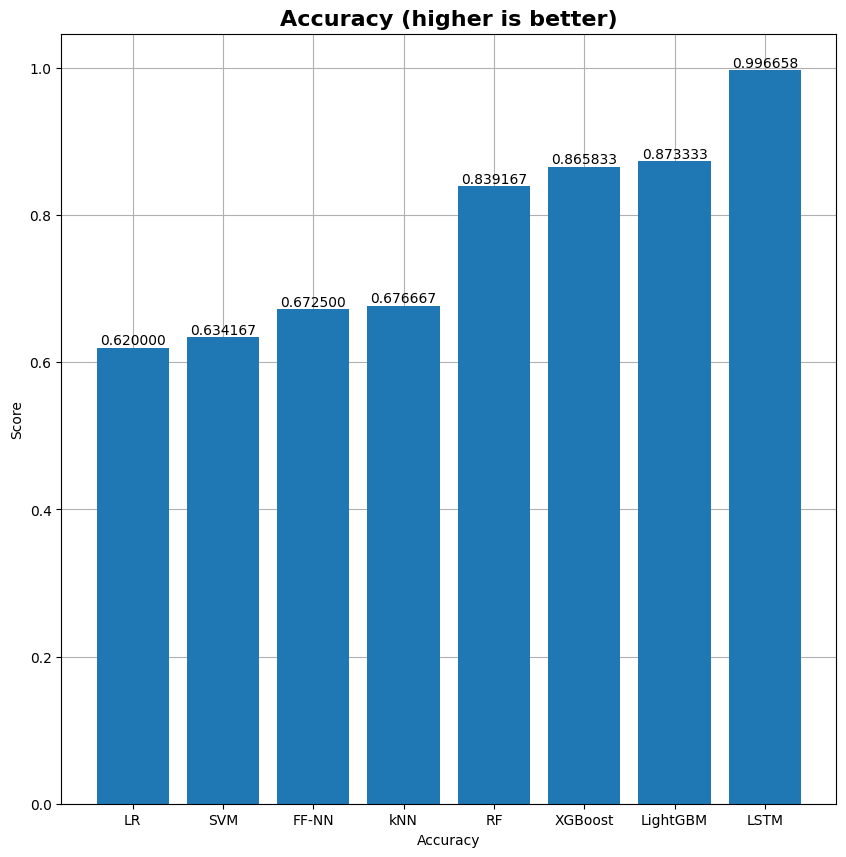

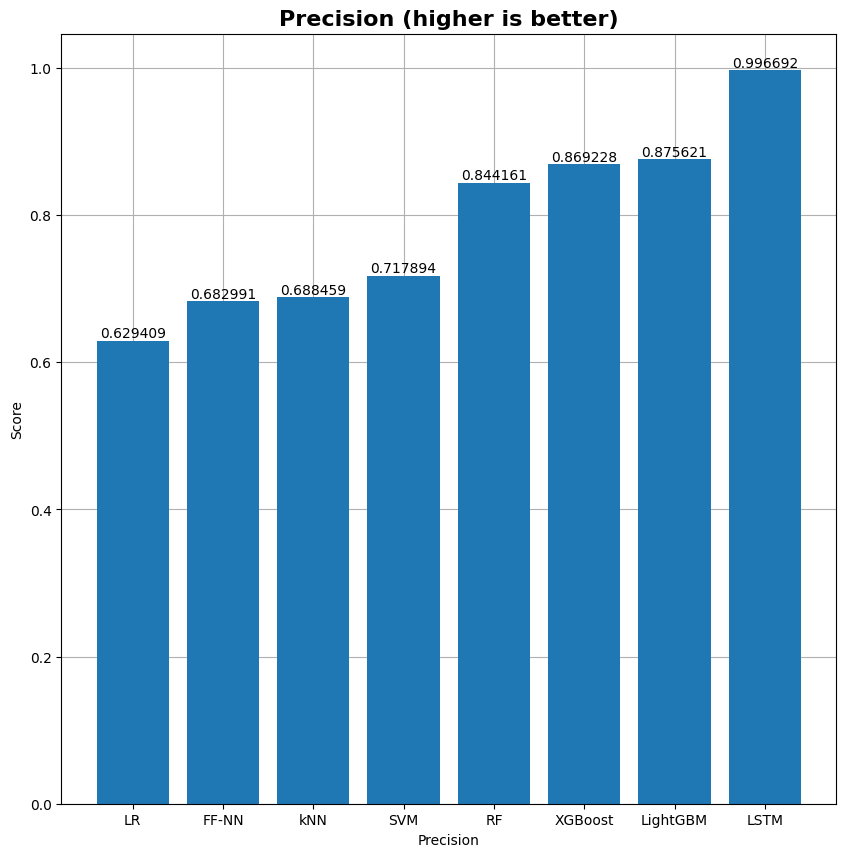

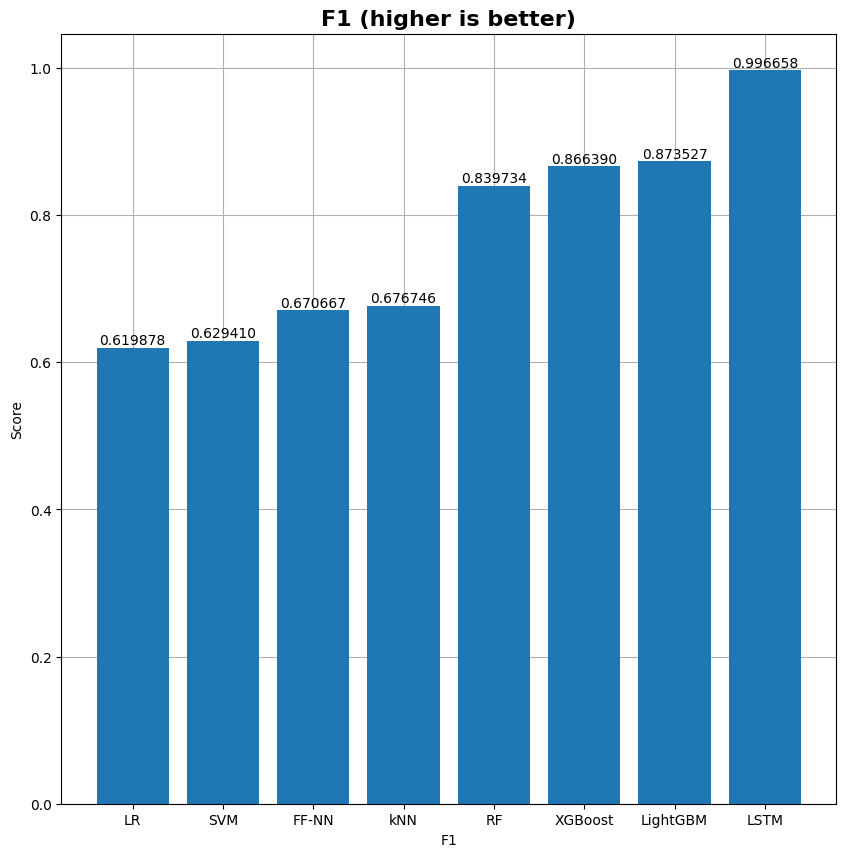

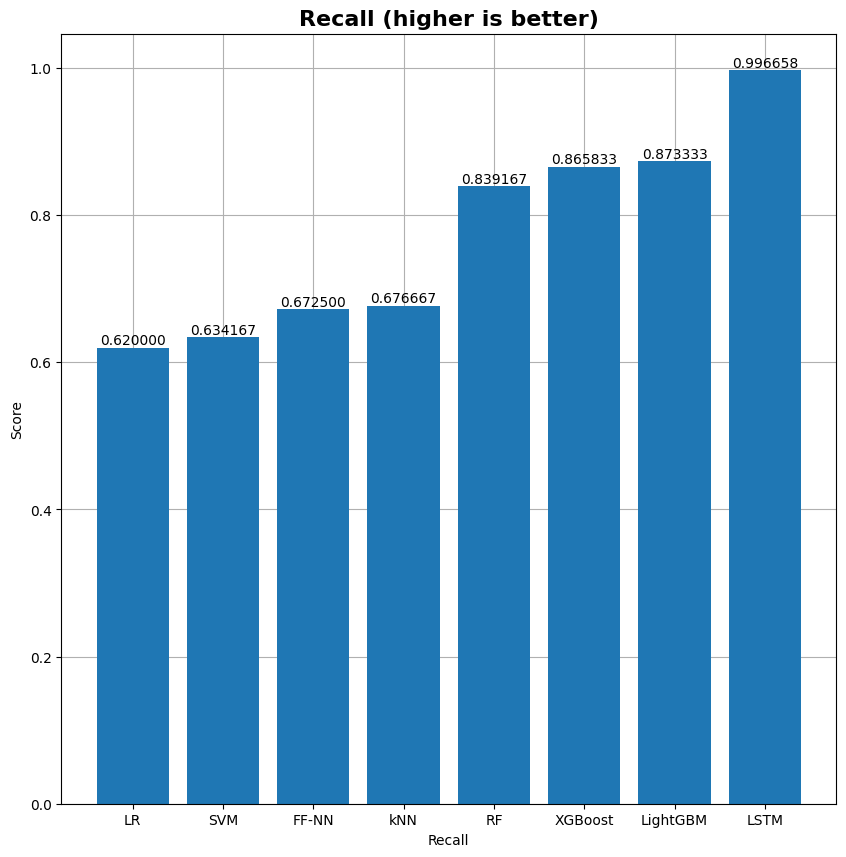

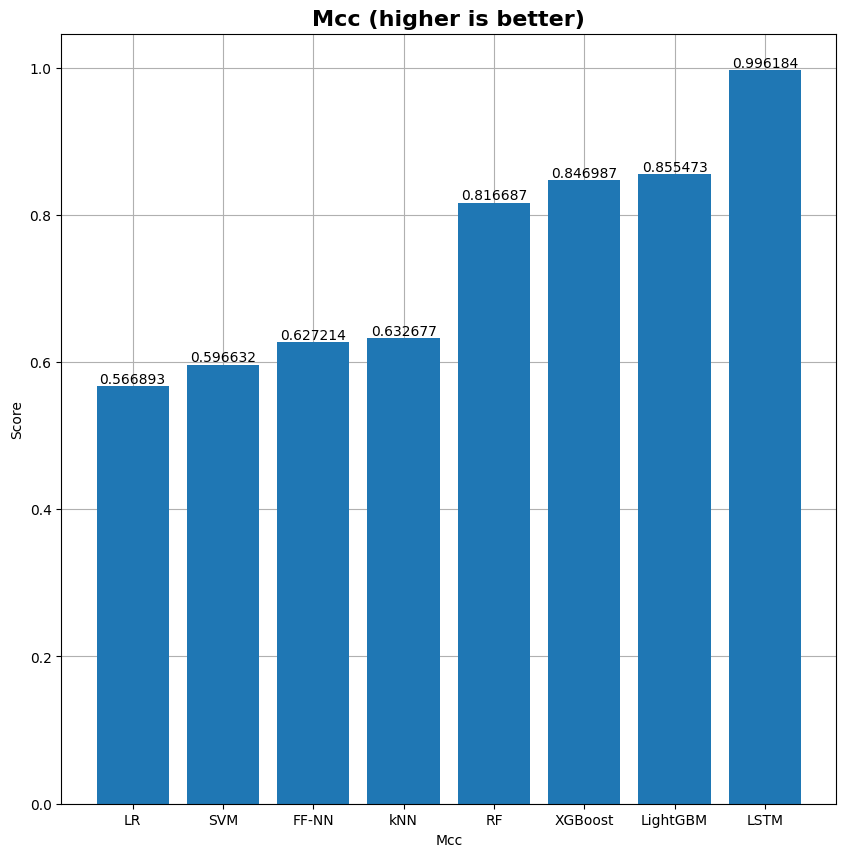

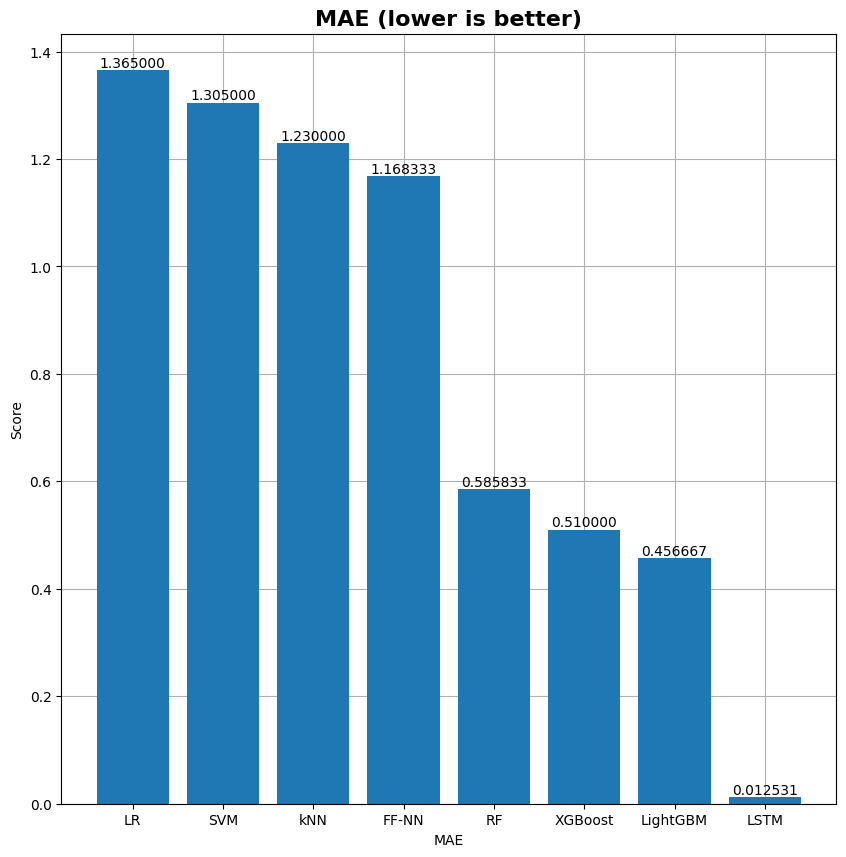

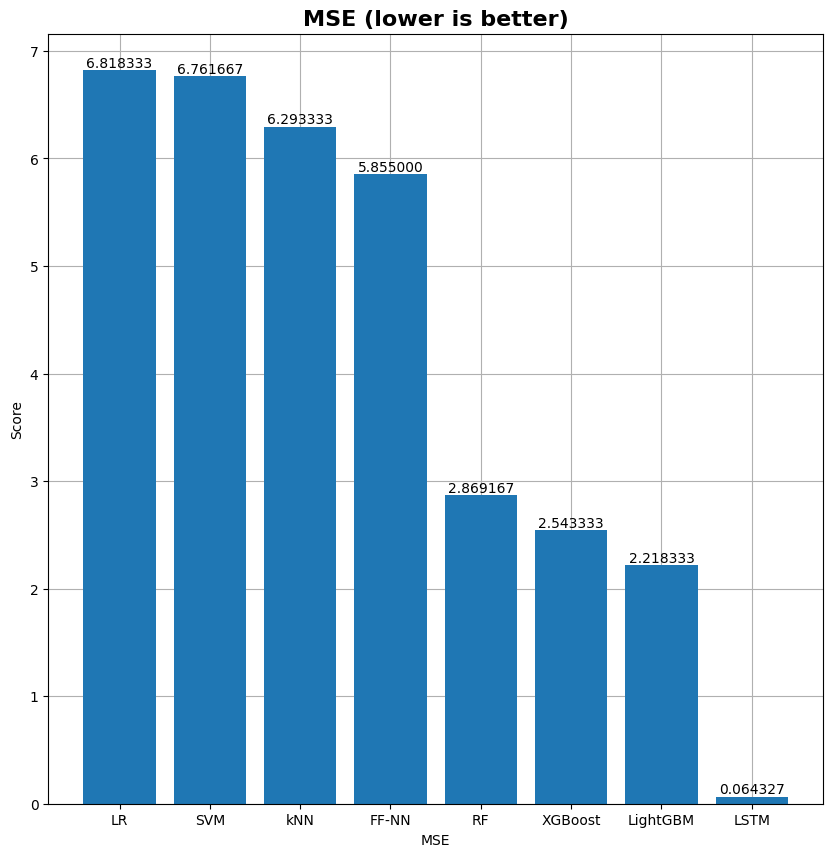

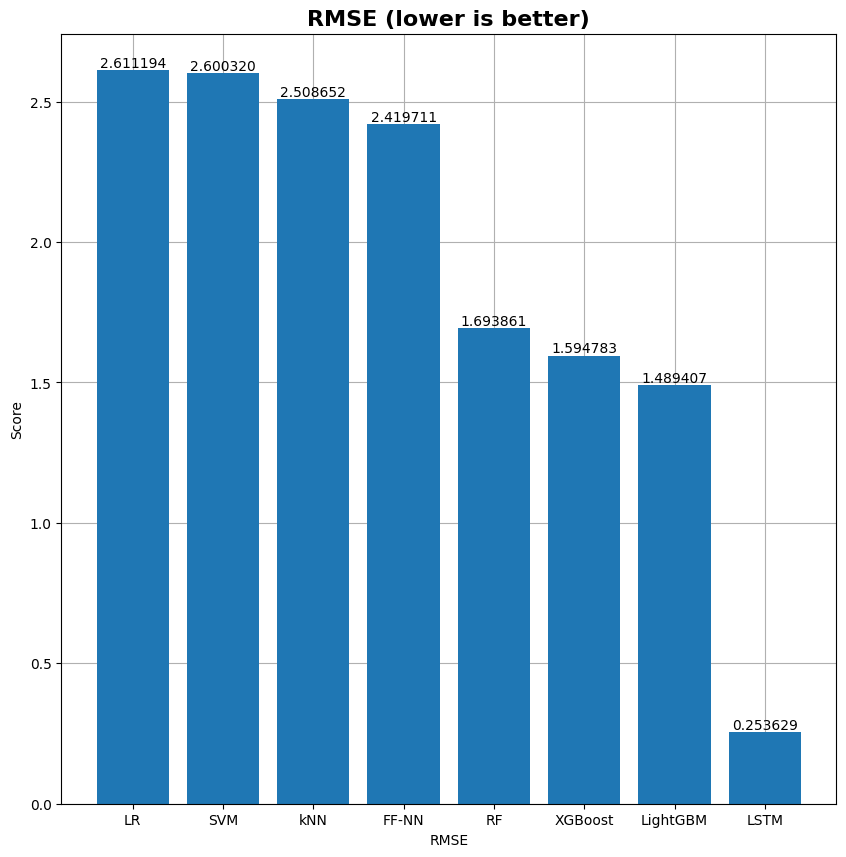

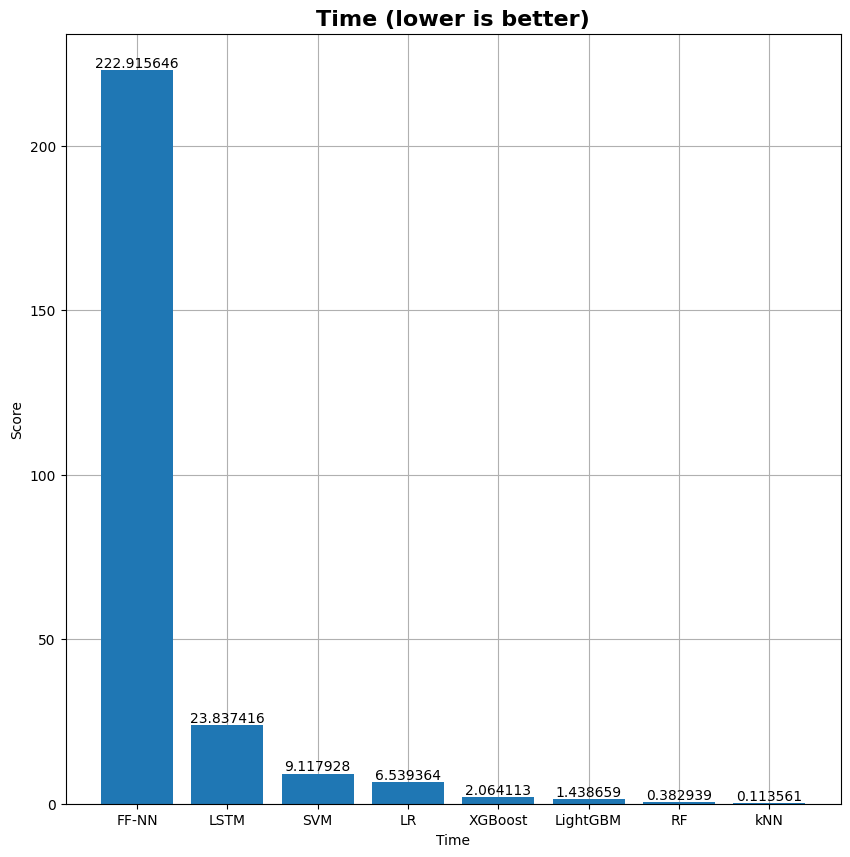

In [80]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])
for x in results_df:
    _dict = {}
    name = results_df[x].name
    for keys, values in zip(range(len(results_df[x].keys())), results_df[x]):
        _dict[results_df[x].keys()[keys]] = values
    result_plot(_dict, name, "multiclass", "")